# A.3 Exact Decomposition for Bilinear Convolutional Tensors

In [1]:
# Now you can import modules from this directory
import torch
import os
from src.plotter import EigenvectorPlotter
from src.heist import load_model
import imageio
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import ToPILImage
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import pickle
from src.heist import create_venv
from torch.utils.data import Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import Dataset, DataLoader
import math


# The following cell is for computing the B_sym matrix, in particular the method is compute_B_sym.

In [2]:
#New set of code refractored from the previous code
def compute_B_sym(W, V):
    """
    Compute the exact tensor decomposition for bilinear convolutional tensors.
    
    Args:
    W, V: Tensors of shape (c_out, c_in, k, k)
    
    Returns:
    B: Tensor of shape (c_out, c_in*k*k, c_in*k*k)
    """
    c_out, c_in, k, _ = W.shape
    B = torch.zeros(c_out, c_in*k*k, c_in*k*k, device=W.device, dtype=W.dtype)
    
    for l in range(c_out):
        W_outl = W[l]  # c_in by k by k
        V_outl = V[l]  # c_in by k by k
        for i in range(c_in):
            for j in range(c_in):
                W_i = W_outl[i]  # k x k
                V_j = V_outl[j]  # k x k
                W_i_f = W_i.reshape(-1)  # k*k
                V_j_f = V_j.reshape(-1)  # k*k
                block = torch.outer(W_i_f, V_j_f)  # k*k x k*k
                B[l, i*k*k:(i+1)*k*k, j*k*k:(j+1)*k*k] = block
    #Symmetrysing B            
    B_sym = torch.zeros_like(B)
    for o in range(c_out):
        B_sym[o] = 0.5 * (B[o] + B[o].T) 
    return B_sym

def compute_eigenvectors(B_sym, topk = None):
    if not topk:
        topk= B_sym.size(-1)
    eigvals, eigvecs = torch.linalg.eigh(B_sym)
    # Initialize tensors to store the top-k eigenvalues and eigenvectors for each class
    top_k_eigenvalues = torch.empty(eigvals.size(0), topk)
    top_k_eigenvectors = torch.empty(eigvecs.size(0), eigvecs.size(1), topk)

    # Sort eigenvalues and eigenvectors for each class separately
    for i in range(eigvals.size(0)):
        sorted_indices = torch.argsort(torch.abs(eigvals[i]), descending=True)
        topk_indices = sorted_indices[:topk]
        top_k_eigenvalues[i] = eigvals[i, topk_indices]
        top_k_eigenvectors[i] = eigvecs[i, :, topk_indices]    
    return top_k_eigenvalues, top_k_eigenvectors  #out_channel, c_in, k, k, topk (num_eigenvectors)

def plot_eigenvector(eigenvector, eigenvalue, output_channel, eigen_index):
    #assume eigenvector is c_in by k by k
    input_channels, height, width = eigenvector.shape
    
    # Calculate the grid size
    grid_size = math.ceil(math.sqrt(input_channels))
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    fig.suptitle(f"Output Channel {output_channel}, Eigenvalue {eigen_index}: {eigenvalue:.4f}")

    # Flatten the axes array if it's 2D
    if grid_size > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    for i in range(input_channels):
        ax = axes[i]
        im = ax.imshow(eigenvector[i], cmap='viridis')
        ax.set_title(f"Input Channel {i}")
        ax.axis('off')
        fig.colorbar(im, ax=ax)
    
    # Hide any unused subplots
    for i in range(input_channels, grid_size * grid_size):
        if grid_size > 1:
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    

In [4]:
class TensorDataset(Dataset):
    def __init__(self, tensors):
        self.tensors = [torch.as_tensor(t, dtype=torch.float32) if isinstance(t, np.ndarray) else t for t in tensors]

    def __len__(self):
        return len(self.tensors)

    def __getitem__(self, idx):
        return self.tensors[idx]

class EigenvectorVisualizer:
    def __init__(self, model, eigenvectors, eigenvalues, target_layer_name, dataset, device):
        self.model = model.to(device)
        self.eigenvectors = eigenvectors.to(device)  #out_channel, c_in, k, k, topk (num_eigenvectors)
        self.eigenvalues = eigenvalues.to(device)  #out_channel, topk (num_eigenvalues)
        self.dataset = dataset
        self.activations = None
        self.device = device
        self.register_hook(target_layer_name)
        self.top_k_activations = {i: [] for i in range(eigenvectors.shape[0] * eigenvectors.shape[-1])}

    def register_hook(self, layer_name):
        for name, module in self.model.named_modules():
            if name == layer_name:
                module.register_forward_hook(self.hook_fn)
                return
        raise ValueError(f"Layer {layer_name} not found in the model.")

    def hook_fn(self, module, input, output):
        self.activations = output.detach()

    def apply_eigenvectors(self, activations):
        batch_size, c_out, h, w = activations.shape
        num_eigenvectors = self.eigenvectors.shape[-1]
        output_activations = torch.zeros((batch_size, c_out, num_eigenvectors, h, w), device=self.device)
        activation_details = []

        for channel in range(c_out):
            #b is batch, c is c_in h is activation height w is action width
            #c is c_in k is kernel height l is kernel width and kernel_height and m is topk
            #after einsum torch.Size([64, 3, 8, 8])
            c_in, k = self.eigenvectors[channel].shape[0], self.eigenvectors[channel].shape[1]
            padding = (k- 1) // 2
            '''
            #filtered = torch.einsum('b c h w,c k l m->b m h w', activations, self.eigenvectors[channel])
            conv = torch.nn.Conv2d(in_channels= c_in,out_channels=1, kernel_size= k, bias = False, padding =padding, stride=1)
            conv.weight = torch.nn.Parameter(self.eigenvectors[channel].unsqueeze(0))
            filtered =  conv(activations)
            print("after einsum" , filtered.shape)
            filtered_squared = filtered ** 2
            sims = self.eigenvalues[channel].view(1, -1, 1, 1) * filtered_squared
            output_activations[:, channel] = sims
            '''

            
            for eig_idx in range(num_eigenvectors):
                conv = torch.nn.Conv2d(in_channels= c_in,out_channels=1, kernel_size= k, bias = False, padding =padding, stride=1)
                conv.weight = torch.nn.Parameter(self.eigenvectors[channel].unsqueeze(0)[:,:,:,:,eig_idx])
                filtered =  conv(activations)
                print("activations and eigenvector", activations.shape, conv.weight.shape)
                filtered_squared = (filtered.squeeze(1))**2
                eig_sims = self.eigenvalues[channel, eig_idx] * filtered_squared
                print("after einsum" , eig_sims.shape)
                #eig_sims: batch out_chan by height by width  -> squeeze dimension 2 : batch by h by w
                output_activations[:, channel, eig_idx] = eig_sims
                #eig_sims = sims[:, eig_idx]
                max_val, max_idx = eig_sims.view(-1).max(0)
                max_batch = max_idx // (h * w)
                max_spatial_idx = max_idx % (h * w)
                max_y = max_spatial_idx // w
                max_x = max_spatial_idx % w

                activation_details.append({
                    'channel': channel,
                    'eigenvector_index': eig_idx,
                    'max_value': max_val.item(),
                    'max_batch': max_batch.item(),
                    'max_y': max_y.item(),
                    'max_x': max_x.item(),
                })

        return output_activations, activation_details

    def process_dataset(self, k=5):
        all_activation_details = []
        dataloader = DataLoader(self.dataset, batch_size=64, shuffle=False)
        
        for batch_idx, batch in enumerate(tqdm(dataloader, desc="Processing batches")):
            batch = batch.to(self.device)
            
            with torch.no_grad():
                batch = batch.squeeze(1)
                self.model(batch)
            _, activation_details = self.apply_eigenvectors(self.activations)
            
            for detail in activation_details:
                max_batch = detail['max_batch']
                max_y, max_x = detail['max_y'], detail['max_x']
                
                # Calculate the segment indices on the full image
                input_h, input_w = batch.shape[1], batch.shape[2]  # Assuming batch shape is [B, H, W, C]
                #print(self.activations.shape)   # B C H W
                scale_factor_h = input_h / self.activations.shape[2]
                scale_factor_w = input_w / self.activations.shape[3]
                #print(scale_factor_h, scale_factor_w)
                img_y = int(max_y * scale_factor_h)
                img_x = int(max_x * scale_factor_w)
                
                
                full_image = batch[max_batch].cpu()

                all_activation_details.append({
                    'batch_idx': batch_idx,
                    **detail,
                    'full_image': full_image,
                    'img_y': img_y,
                    'img_x': img_x
                })

        self.top_k_activations = {}
        for channel in range(self.eigenvectors.shape[0]):
            for eig_idx in range(self.eigenvectors.shape[-1]):
                eig_activations = [det for det in all_activation_details 
                                if det['channel'] == channel and det['eigenvector_index'] == eig_idx]
                eig_activations.sort(key=lambda x: x['max_value'], reverse=True)
                self.top_k_activations[(channel, eig_idx)] = eig_activations[:k]

        return self.top_k_activations

    def display_top_activating_segments(self):
        for (channel, eig_idx), activations in self.top_k_activations.items():
            plt.figure(figsize=(20, 4))  # Adjusted for a single row of images
            for idx, activation in enumerate(activations,1):
                img_idx = activation['batch_idx']
                img_y = activation['img_y']
                img_x = activation['img_x']
                full_image = activation['full_image']


                # Normalize the image if it's not already in 0-1 range
                full_image = full_image.float() / 255.0 if full_image.max() > 1 else full_image

                # Plot full image
                ax = plt.subplot(1, 5, idx)
                plt.imshow(full_image.cpu().numpy())
                plt.title(f'Image {img_idx}')
                plt.axis('off')

                scale_factor_h = full_image.shape[0] / self.activations.shape[2]
                scale_factor_w = full_image.shape[0]/ self.activations.shape[3]
                segment_h, segment_w = scale_factor_h,scale_factor_w
                print("segment size, ", segment_h, segment_w)

                # Add a square to indicate the segment
                rect = patches.Rectangle((img_x - segment_w/2, img_y - segment_h/2), 
                                        segment_w, segment_h, 
                                        linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

            plt.suptitle(f'Channel {channel}, Eigenvector {eig_idx} - Top 5 Activating Images')
            plt.tight_layout()
            plt.show()

In [5]:
model_path = '/mnt/ssd-1/mechinterp/narmeen/bilinear_experiments_official/bilinear_experiments/bilinear_models/bimpala_heist_simplified.pt'

model =load_model(model_path,7)
print(model)
#state dictionary of the model
for k in model.state_dict():
    print(k)
state_dict = model.state_dict()

/mnt/ssd-1/mechinterp/narmeen/bilinear_experiments_official/bilinear_experiments/src/heist.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model

Model loaded from /mnt/ssd-1/mechinterp/narmeen/bilinear_experiments_official/bilinear_experiments/bilinear_models/bimpala_heist_simplified.pt
BimpalaCNN(
  (conv): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv_seqs): ModuleList(
    (0-2): 3 x ConvSequence(
      (max_pool2d): MaxPool2d(kernel_size=7, stride=2, padding=3, dilation=1, ceil_mode=False)
      (res_block0): ResidualBlock(
        (conv0): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (conv1): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      )
      (res_block1): ResidualBlock(
        (conv0): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (conv1): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      )
    )
  )
  (hidden_fc1): Linear(in_features=2048, out_features=256, bias=False)
  (hidden_fc2): Linear(in_features=2048, out_features=256, bias=False)
 

# Here we are using compute_sym to get the eigenfilters on layer: conv_seqs.2.res_block1

torch.Size([32, 3]) torch.Size([32, 32, 7, 7, 3])


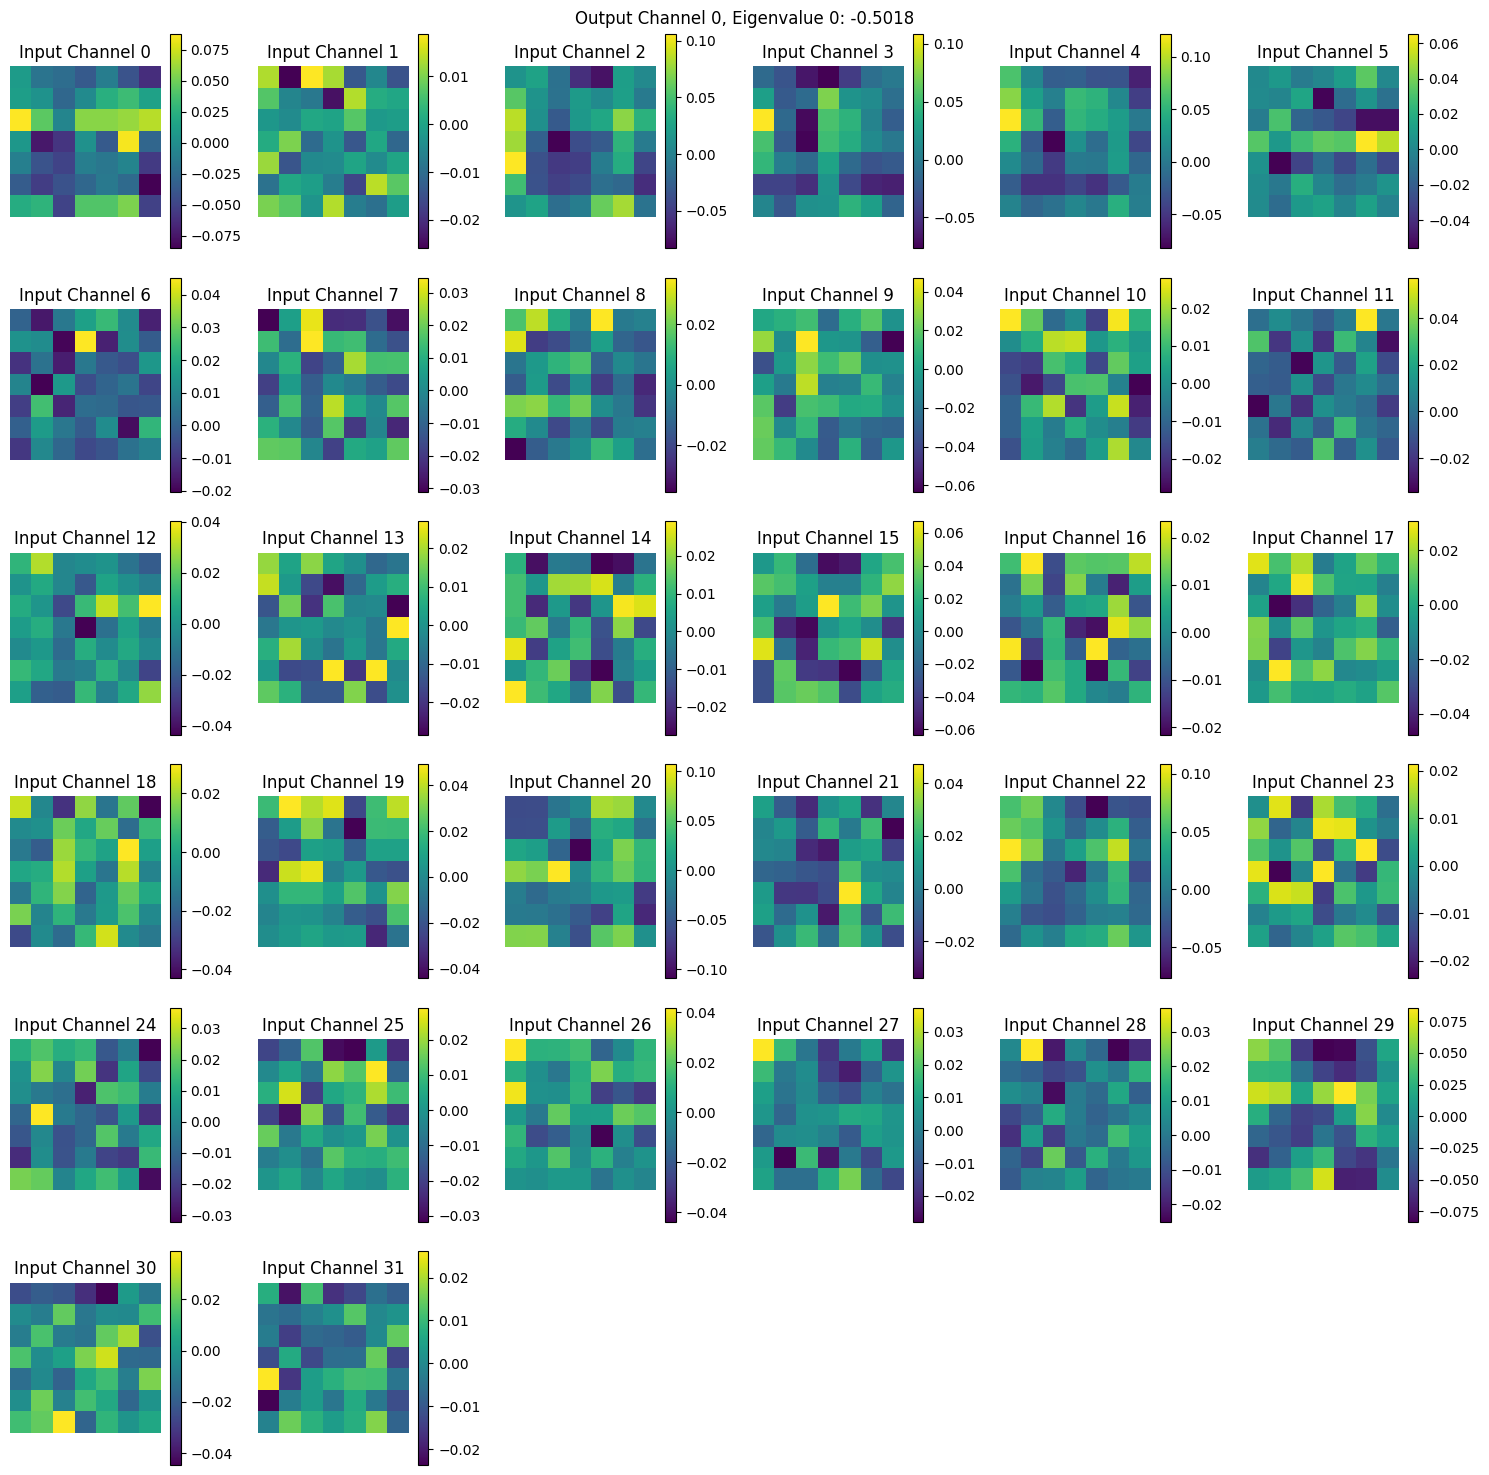

KeyboardInterrupt: 

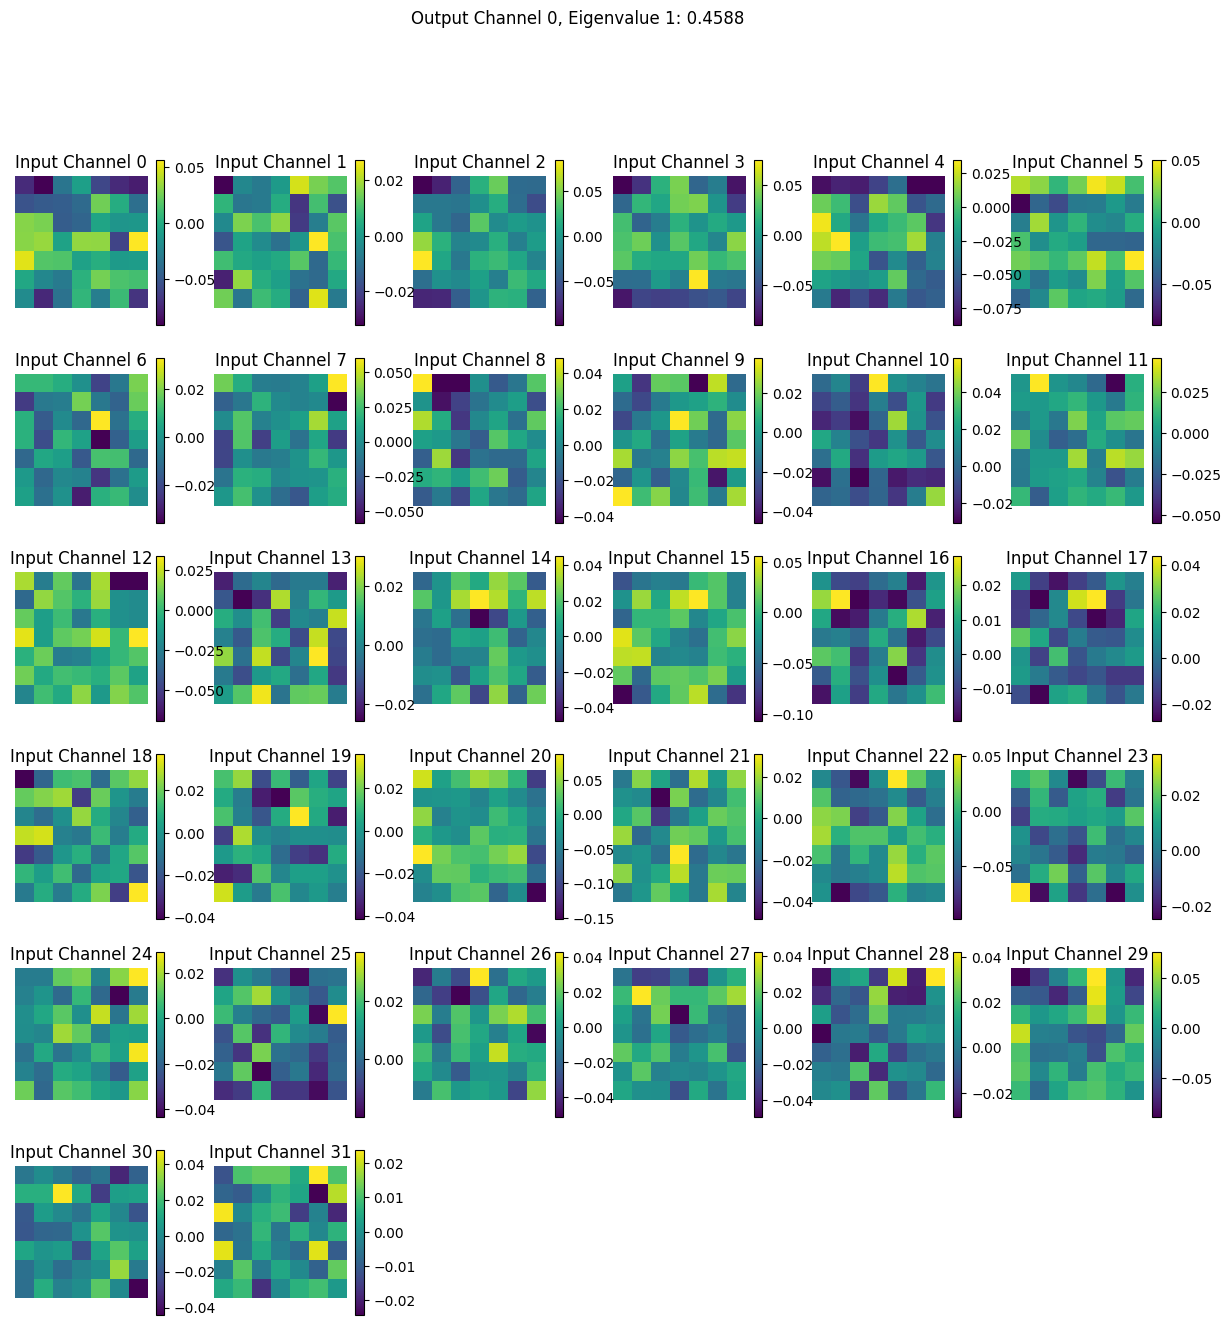

In [ ]:
#So inpaticular, we take W bilinear_gated with V in the original network
W = state_dict['conv_seqs.2.res_block1.conv0.weight']
V = state_dict['conv_seqs.2.res_block1.conv1.weight']

# Create the 3D block matrix
B_sym = compute_B_sym(W, V)
topk_eigvals, topk_eigvecs = compute_eigenvectors(B_sym, topk= 3)
topk_eigvecs = topk_eigvecs.reshape(topk_eigvecs.size(0),W.size(1),W.size(2),W.size(3),topk_eigvecs.size(-1))
print(topk_eigvals.shape, topk_eigvecs.shape)

for output_channel in range(topk_eigvals.shape[0]):
    for eigen_index in range(topk_eigvals.shape[1]):
        eigenvalue = topk_eigvals[output_channel, eigen_index]
        eigenvector = topk_eigvecs[output_channel, :, :, :, eigen_index]       
        plot_eigenvector(eigenvector, eigenvalue, output_channel, eigen_index)


In [77]:
W = torch.rand(2, 6, 18, 18)  # c_out=3, c_in=2, k=4
V = torch.rand(2, 6, 18, 18)  # Same shape as W

# Create the 3D block matrix
B = compute_block(W, V)

print("Shape of W:", W.shape)
print("Shape of V:", V.shape)
print("Shape of B:", B.shape)

for k in range(W.size(0)):
    for i in range(W.size(1)):
        for j in range(W.size(1)):
            output =torch.outer(W[k][i].reshape(-1),V[k][j].reshape(-1))
            for n in range(W.size(2)**2):
                assert torch.allclose(B[k][i*W.size(2)**2+n,j*W.size(2)**2: (j+1)*W.size(2)**2],output[n])
            for n in range(W.size(2)**2):            
                assert torch.allclose(B[k][i*W.size(2)**2:(i+1)*W.size(2)**2,j*W.size(2)**2+n],output[:,n])


Shape of W: torch.Size([2, 6, 18, 18])
Shape of V: torch.Size([2, 6, 18, 18])
Shape of B: torch.Size([2, 1944, 1944])


In [6]:
def load_and_combine_datasets(num_files, dataset_folder=""):
    # List to hold all observations from all datasets
    all_observations = []
    
    # Generate file names based on known naming pattern
    dataset_files = [f'datasets/heist_dataset_progress_20_batch{i}.pickle' for i in range(num_files)]

    # Loop through each file, load it, and extend the master list
    for dataset_file in dataset_files:
        file_path = os.path.join(dataset_folder, dataset_file)
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            all_observations.extend(data)
    
    return all_observations
dataset = load_and_combine_datasets(5)

In [5]:
W = state_dict['conv_seqs.2.res_block1.conv0.weight']
V = state_dict['conv_seqs.2.res_block1.conv1.weight']

# Create the 3D block matrix
B_sym = compute_B_sym(W, V)
topk_eigvals, topk_eigvecs = compute_eigenvectors(B_sym, topk= 3)
topk_eigvecs = topk_eigvecs.reshape(topk_eigvecs.size(0),W.size(1),W.size(2),W.size(3),topk_eigvecs.size(-1))
print(topk_eigvals.shape, topk_eigvecs.shape)


torch.Size([32, 3]) torch.Size([32, 32, 7, 7, 3])


Processing batches:   0%|          | 0/2 [00:00<?, ?it/s]

activations and eigenvector torch.Size([64, 32, 8, 8]) torch.Size([1, 32, 7, 7])
after einsum torch.Size([64, 8, 8])
activations and eigenvector torch.Size([64, 32, 8, 8]) torch.Size([1, 32, 7, 7])
after einsum torch.Size([64, 8, 8])
activations and eigenvector torch.Size([64, 32, 8, 8]) torch.Size([1, 32, 7, 7])
after einsum torch.Size([64, 8, 8])
activations and eigenvector torch.Size([64, 32, 8, 8]) torch.Size([1, 32, 7, 7])
after einsum torch.Size([64, 8, 8])
activations and eigenvector torch.Size([64, 32, 8, 8]) torch.Size([1, 32, 7, 7])
after einsum torch.Size([64, 8, 8])
activations and eigenvector torch.Size([64, 32, 8, 8]) torch.Size([1, 32, 7, 7])
after einsum torch.Size([64, 8, 8])
activations and eigenvector torch.Size([64, 32, 8, 8]) torch.Size([1, 32, 7, 7])
after einsum torch.Size([64, 8, 8])
activations and eigenvector torch.Size([64, 32, 8, 8]) torch.Size([1, 32, 7, 7])
after einsum torch.Size([64, 8, 8])
activations and eigenvector torch.Size([64, 32, 8, 8]) torch.Siz

Processing batches:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s]

activations and eigenvector torch.Size([64, 32, 8, 8]) torch.Size([1, 32, 7, 7])
after einsum torch.Size([64, 8, 8])
activations and eigenvector torch.Size([64, 32, 8, 8]) torch.Size([1, 32, 7, 7])
after einsum torch.Size([64, 8, 8])
activations and eigenvector torch.Size([64, 32, 8, 8]) torch.Size([1, 32, 7, 7])
after einsum torch.Size([64, 8, 8])
activations and eigenvector torch.Size([64, 32, 8, 8]) torch.Size([1, 32, 7, 7])
after einsum torch.Size([64, 8, 8])
activations and eigenvector torch.Size([64, 32, 8, 8]) torch.Size([1, 32, 7, 7])
after einsum torch.Size([64, 8, 8])
activations and eigenvector torch.Size([64, 32, 8, 8]) torch.Size([1, 32, 7, 7])
after einsum torch.Size([64, 8, 8])
activations and eigenvector torch.Size([64, 32, 8, 8]) torch.Size([1, 32, 7, 7])
after einsum torch.Size([64, 8, 8])
activations and eigenvector torch.Size([64, 32, 8, 8]) torch.Size([1, 32, 7, 7])
after einsum torch.Size([64, 8, 8])
activations and eigenvector torch.Size([64, 32, 8, 8]) torch.Siz

Processing batches: 100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

activations and eigenvector torch.Size([36, 32, 8, 8]) torch.Size([1, 32, 7, 7])
after einsum torch.Size([36, 8, 8])
activations and eigenvector torch.Size([36, 32, 8, 8]) torch.Size([1, 32, 7, 7])
after einsum torch.Size([36, 8, 8])
activations and eigenvector torch.Size([36, 32, 8, 8]) torch.Size([1, 32, 7, 7])
after einsum torch.Size([36, 8, 8])
activations and eigenvector torch.Size([36, 32, 8, 8]) torch.Size([1, 32, 7, 7])
after einsum torch.Size([36, 8, 8])
activations and eigenvector torch.Size([36, 32, 8, 8]) torch.Size([1, 32, 7, 7])
after einsum torch.Size([36, 8, 8])
activations and eigenvector torch.Size([36, 32, 8, 8]) torch.Size([1, 32, 7, 7])
after einsum torch.Size([36, 8, 8])
activations and eigenvector torch.Size([36, 32, 8, 8]) torch.Size([1, 32, 7, 7])
after einsum torch.Size([36, 8, 8])
activations and eigenvector torch.Size([36, 32, 8, 8]) torch.Size([1, 32, 7, 7])
after einsum torch.Size([36, 8, 8])
activations and eigenvector torch.Size([36, 32, 8, 8]) torch.Siz

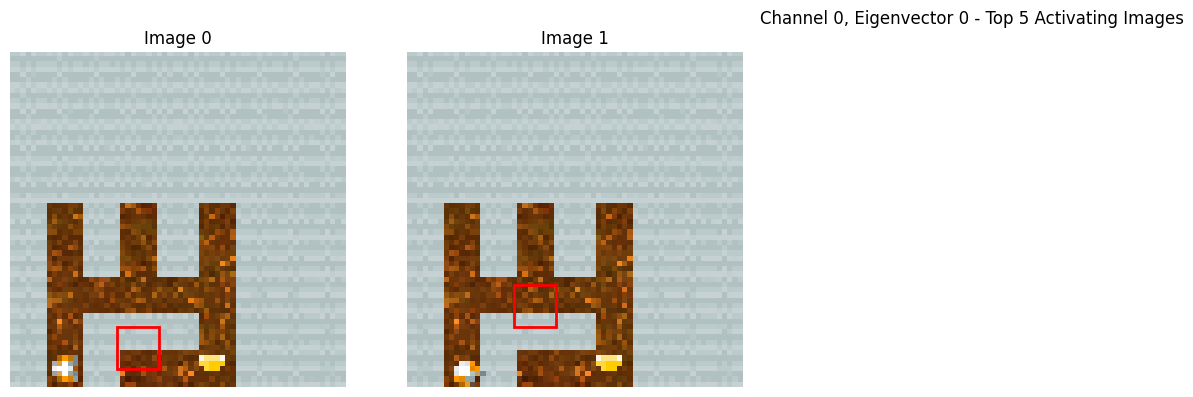

segment size,  8.0 8.0
segment size,  8.0 8.0


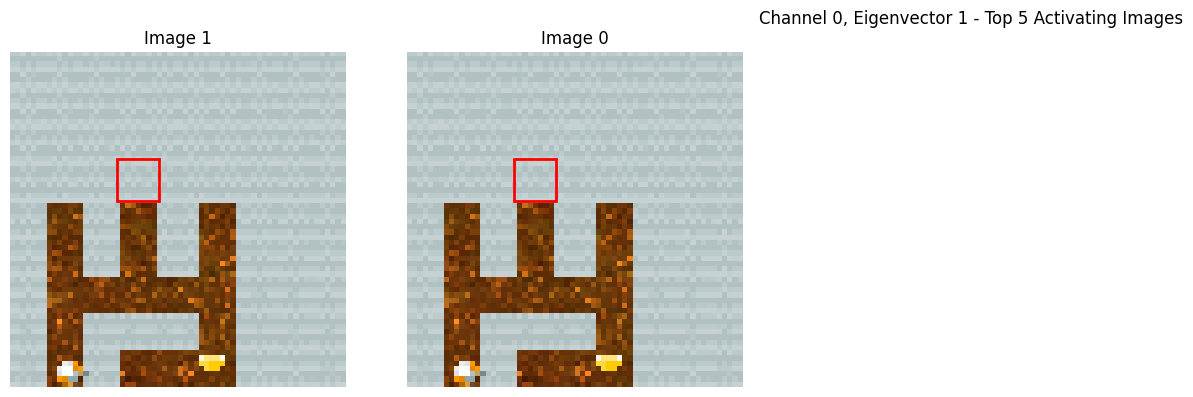

segment size,  8.0 8.0
segment size,  8.0 8.0


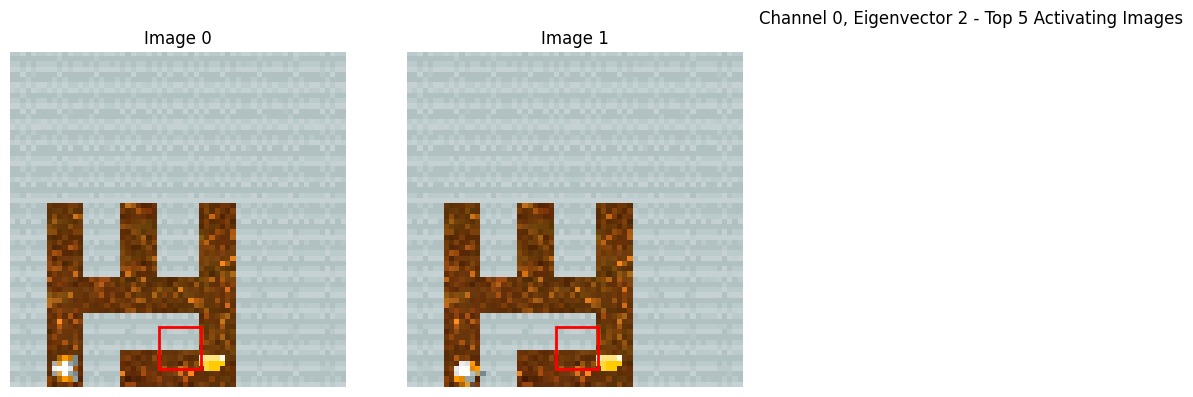

segment size,  8.0 8.0
segment size,  8.0 8.0


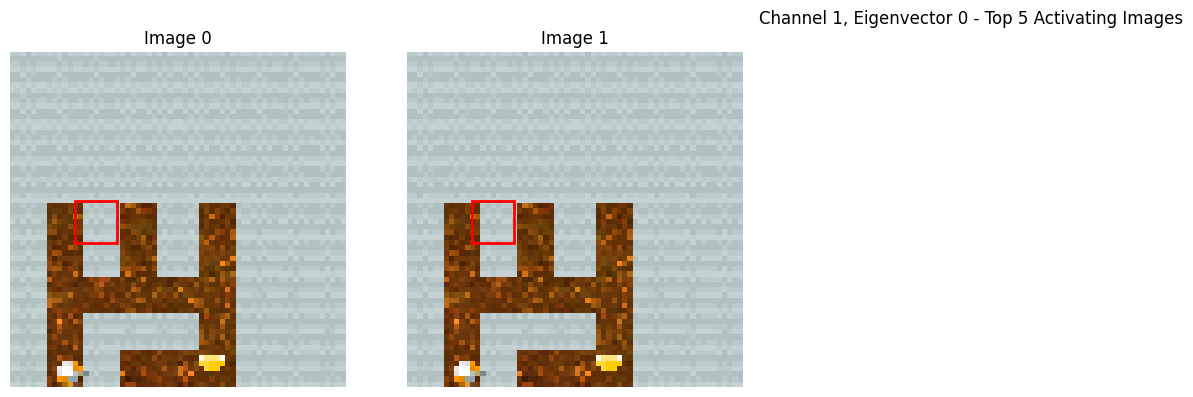

segment size,  8.0 8.0
segment size,  8.0 8.0


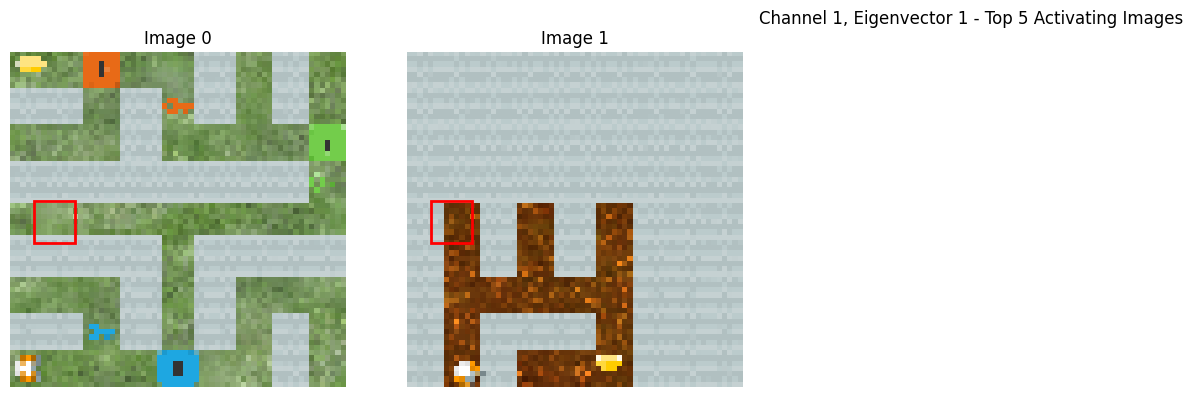

segment size,  8.0 8.0
segment size,  8.0 8.0


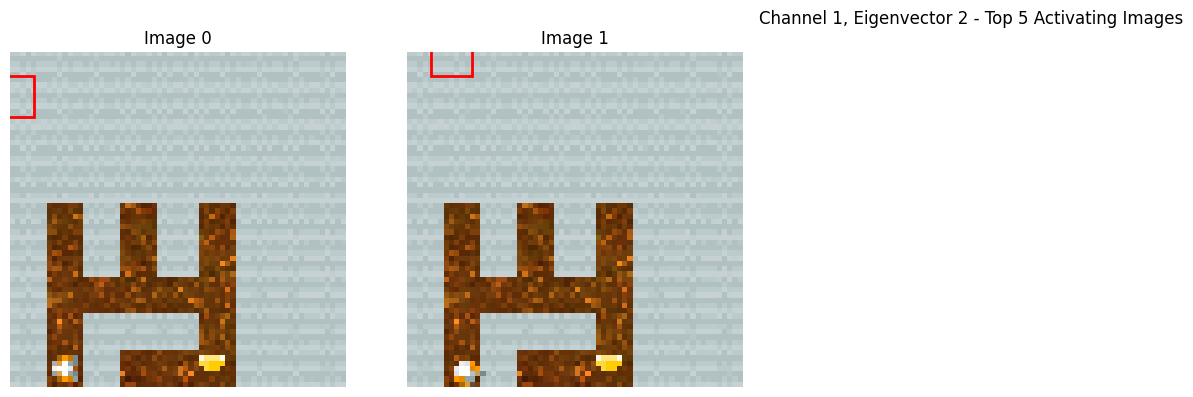

segment size,  8.0 8.0
segment size,  8.0 8.0


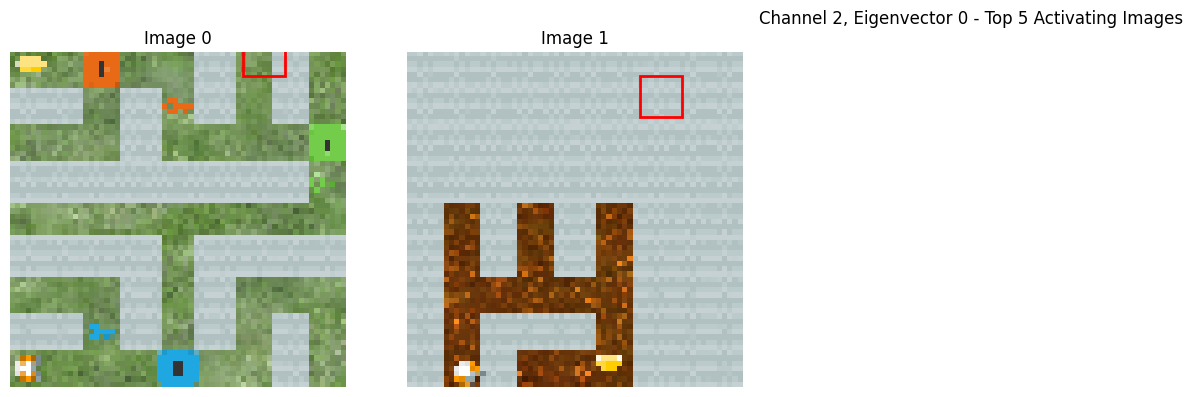

segment size,  8.0 8.0
segment size,  8.0 8.0


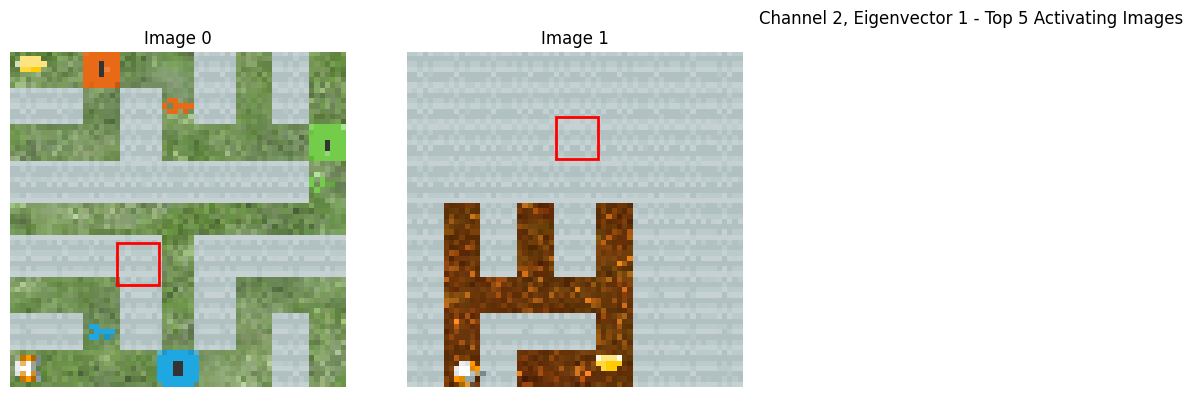

segment size,  8.0 8.0
segment size,  8.0 8.0


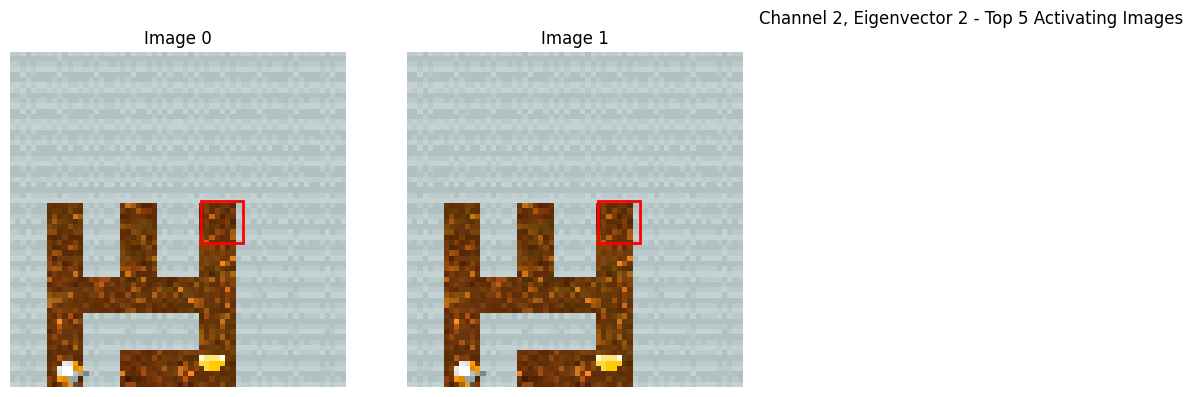

segment size,  8.0 8.0
segment size,  8.0 8.0


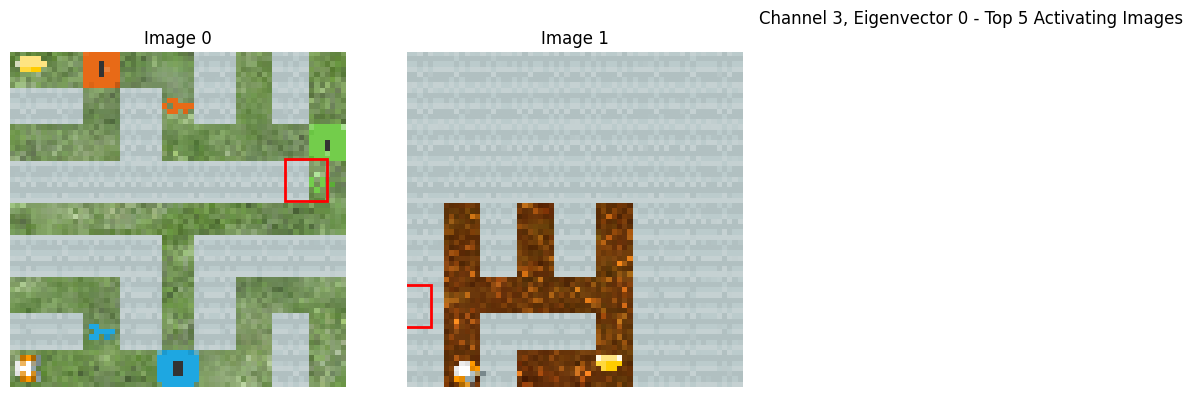

segment size,  8.0 8.0
segment size,  8.0 8.0


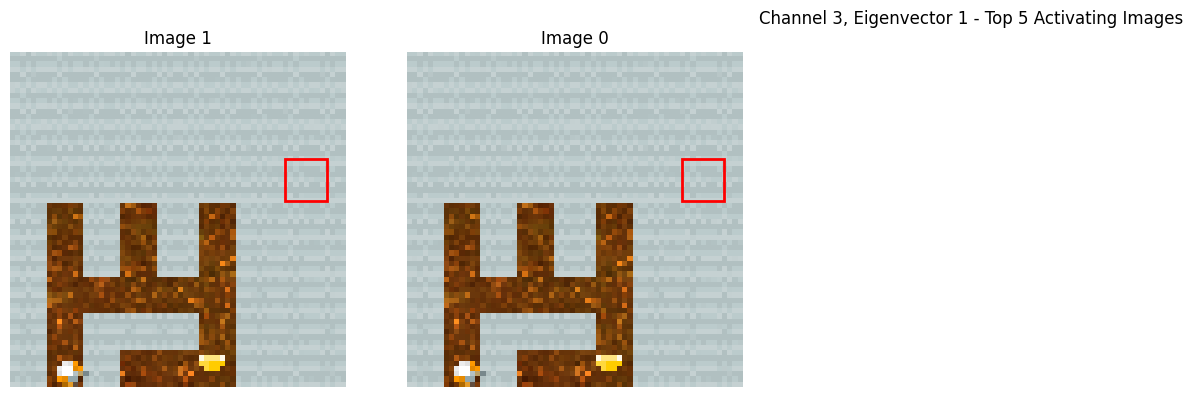

segment size,  8.0 8.0
segment size,  8.0 8.0


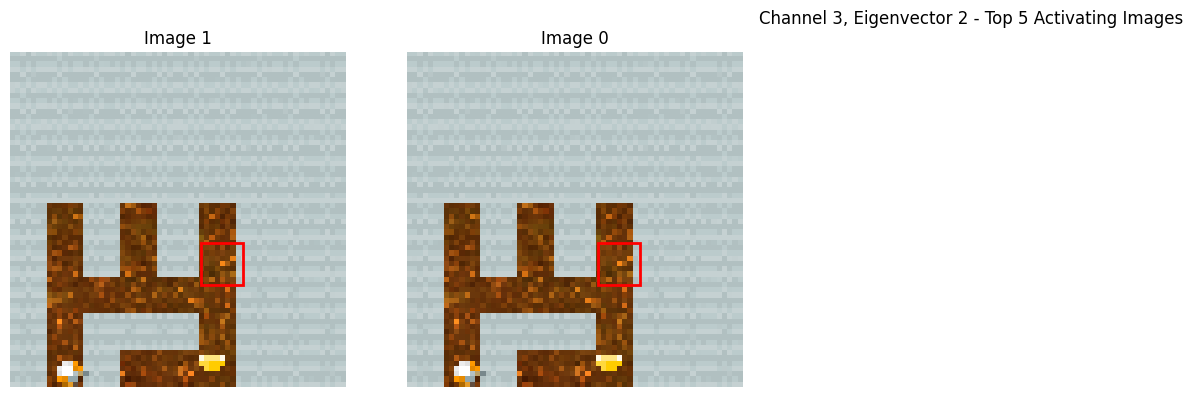

segment size,  8.0 8.0
segment size,  8.0 8.0


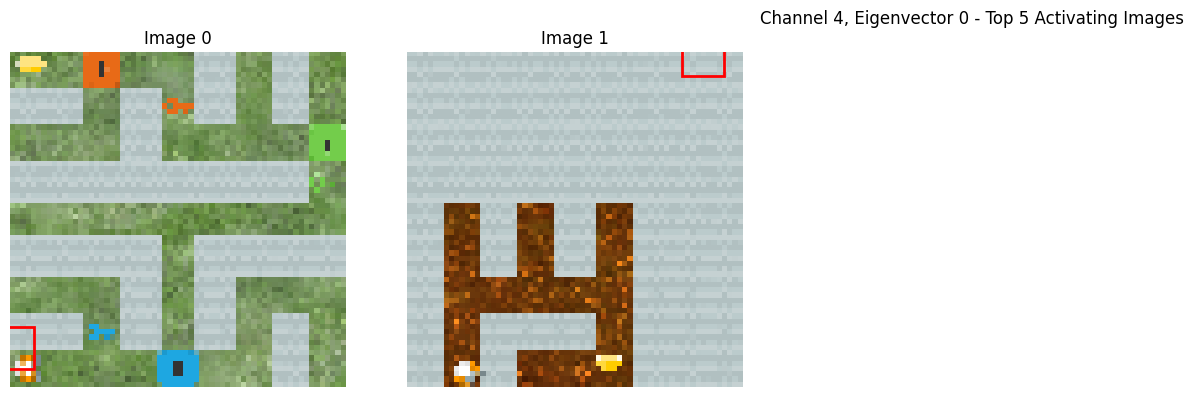

segment size,  8.0 8.0
segment size,  8.0 8.0


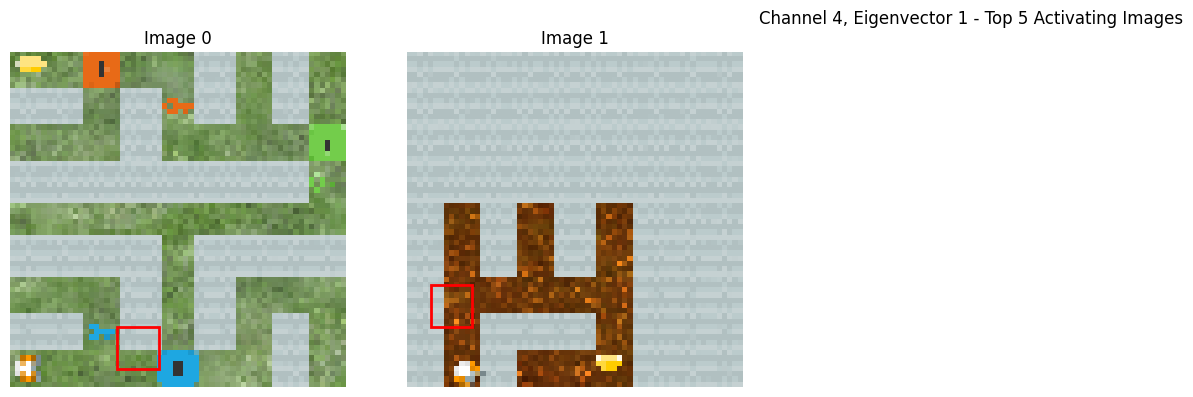

segment size,  8.0 8.0
segment size,  8.0 8.0


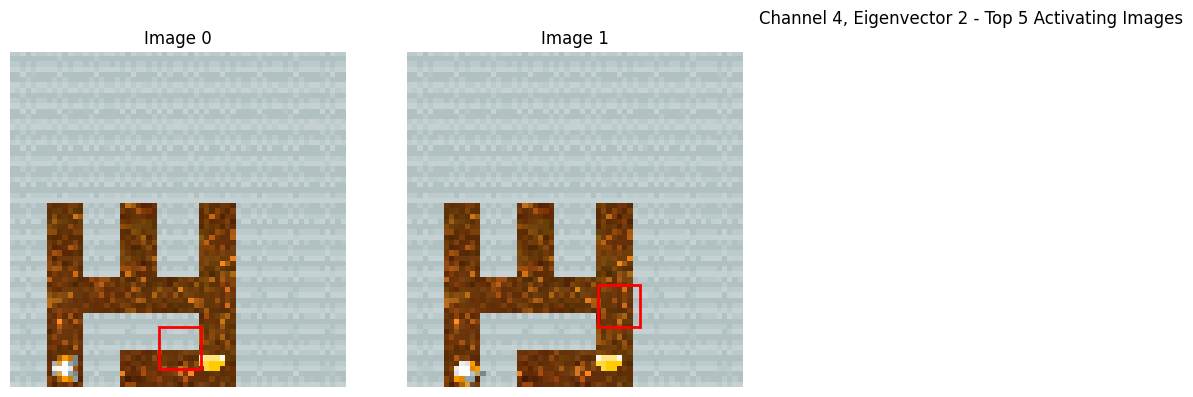

segment size,  8.0 8.0
segment size,  8.0 8.0


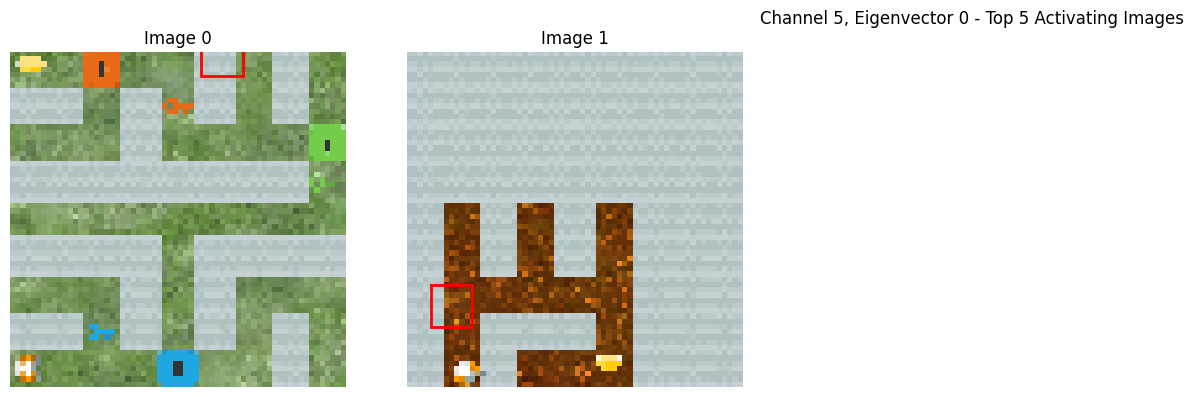

segment size,  8.0 8.0
segment size,  8.0 8.0


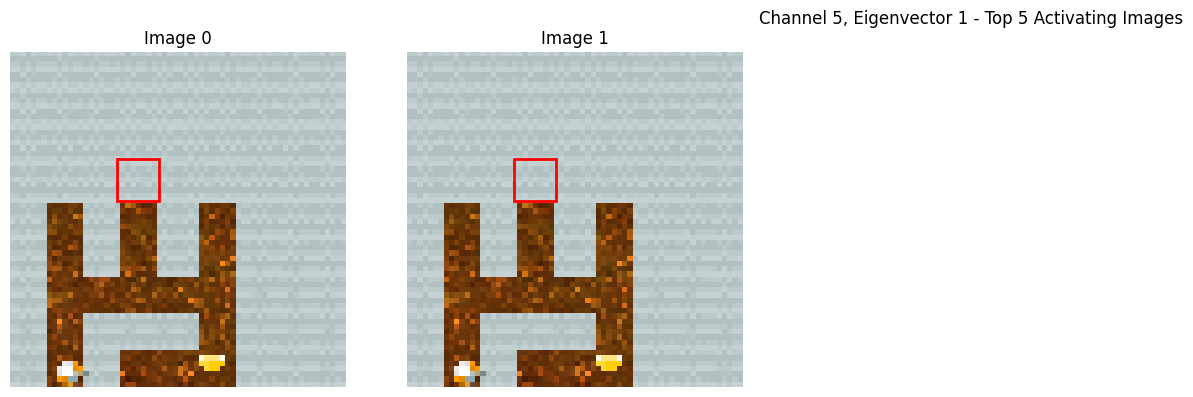

segment size,  8.0 8.0
segment size,  8.0 8.0


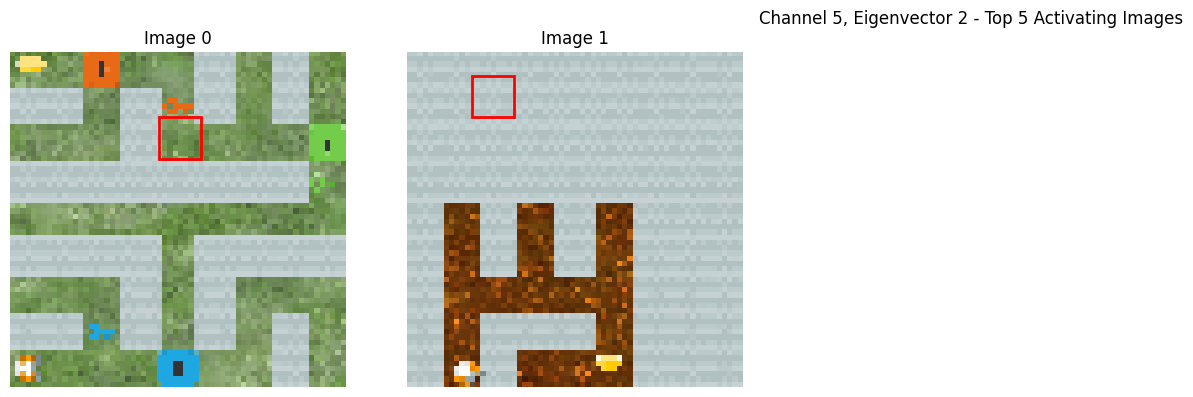

segment size,  8.0 8.0
segment size,  8.0 8.0


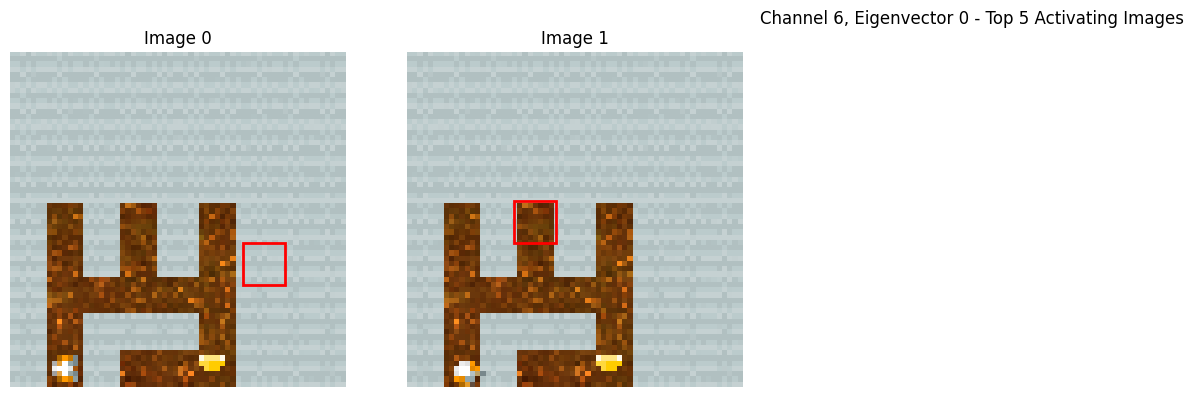

segment size,  8.0 8.0
segment size,  8.0 8.0


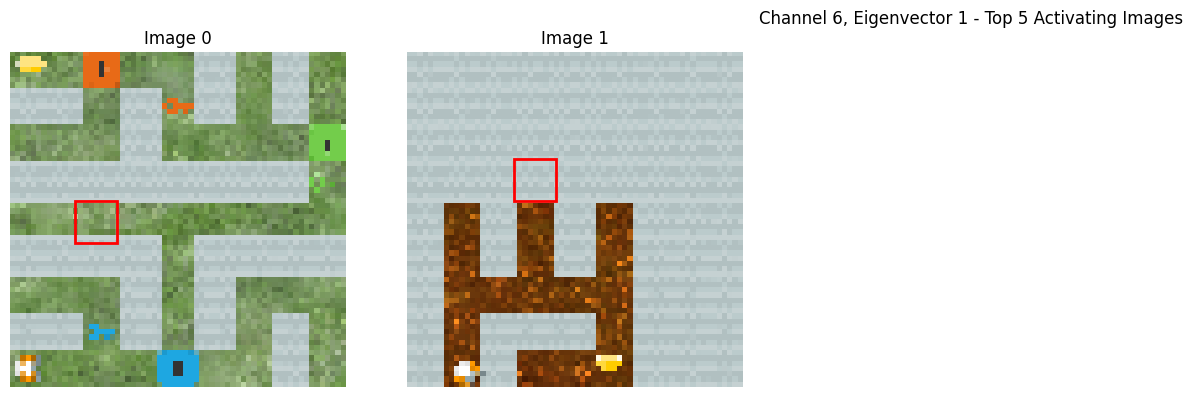

segment size,  8.0 8.0
segment size,  8.0 8.0


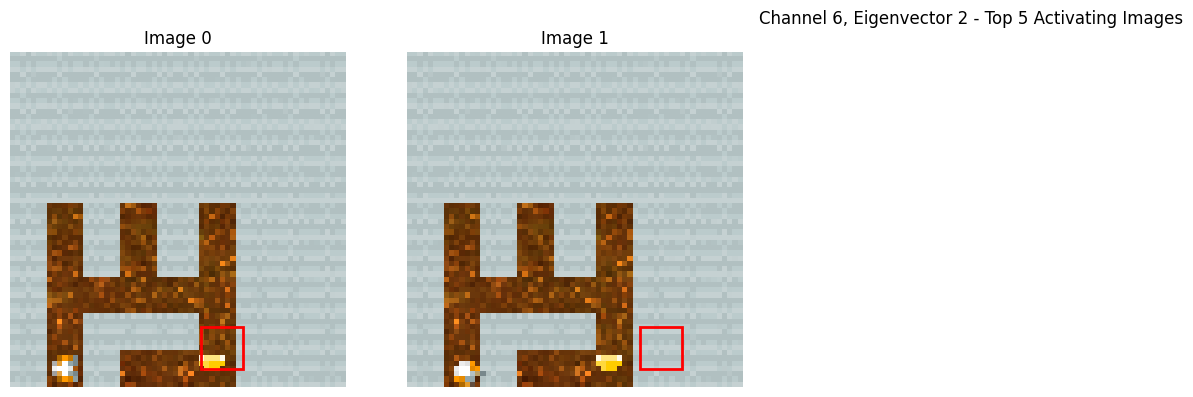

segment size,  8.0 8.0
segment size,  8.0 8.0


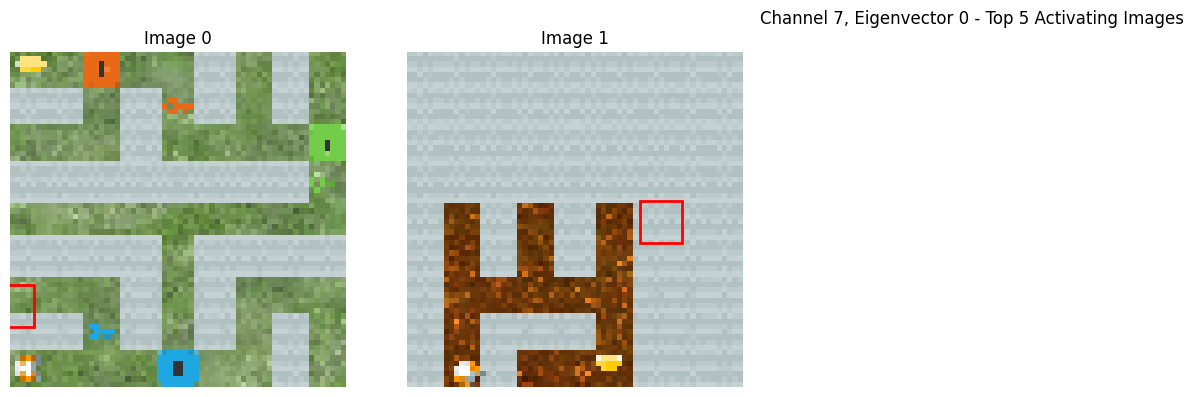

segment size,  8.0 8.0
segment size,  8.0 8.0


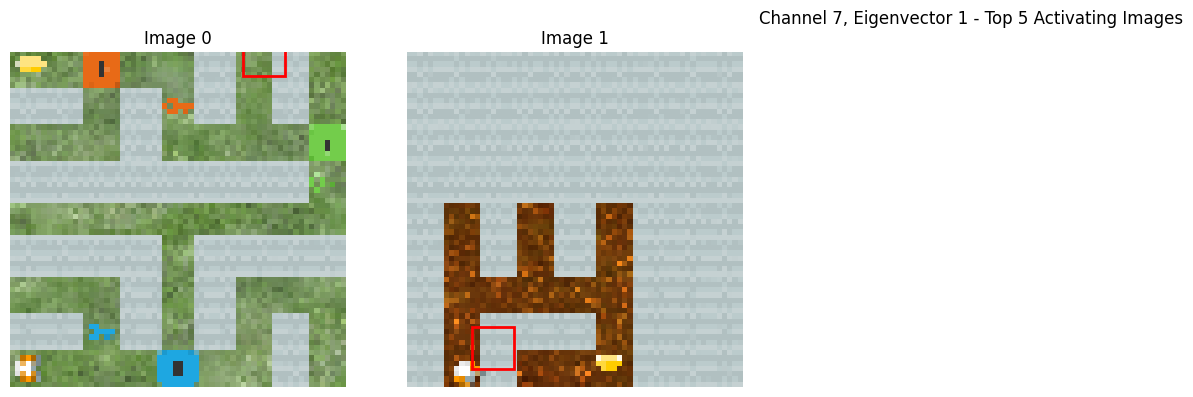

segment size,  8.0 8.0
segment size,  8.0 8.0


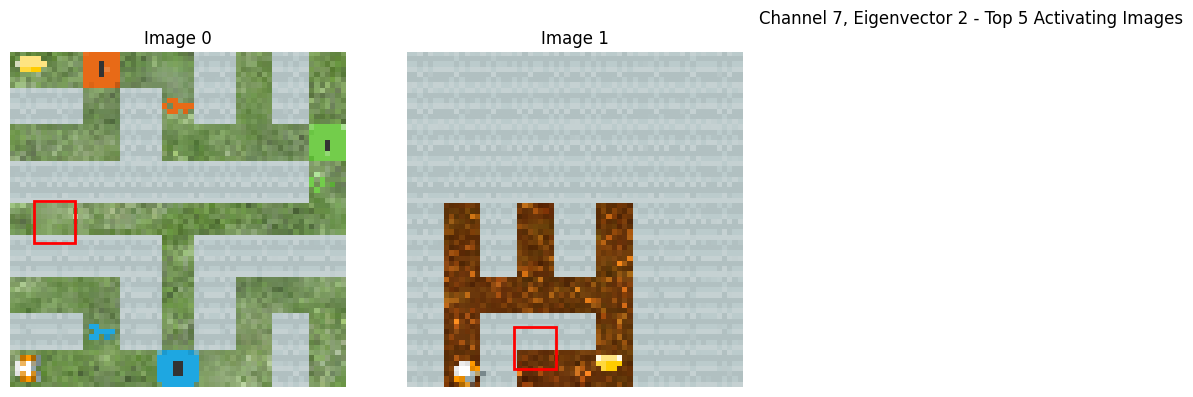

segment size,  8.0 8.0
segment size,  8.0 8.0


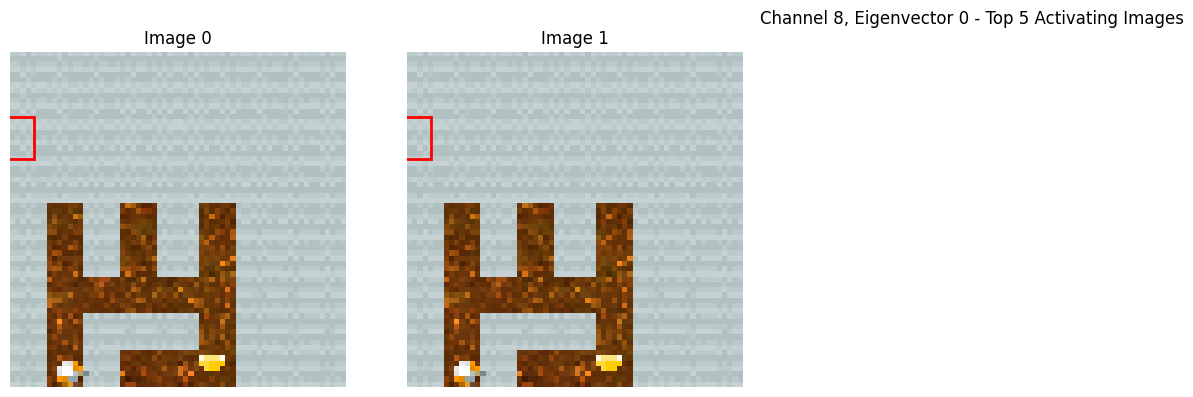

segment size,  8.0 8.0
segment size,  8.0 8.0


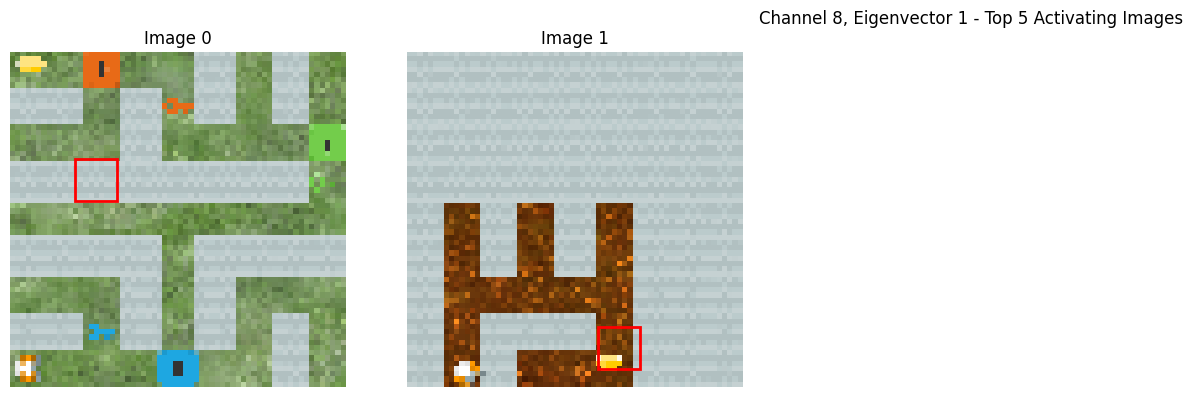

segment size,  8.0 8.0
segment size,  8.0 8.0


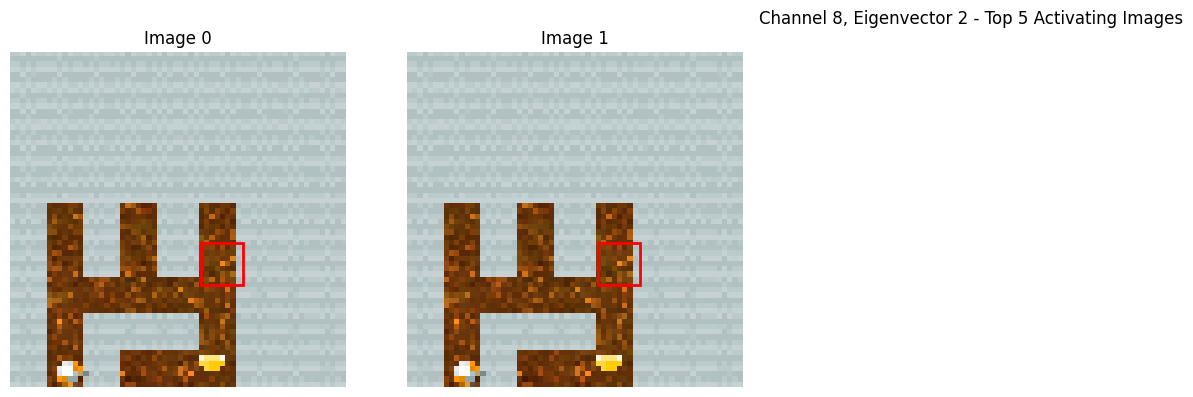

segment size,  8.0 8.0
segment size,  8.0 8.0


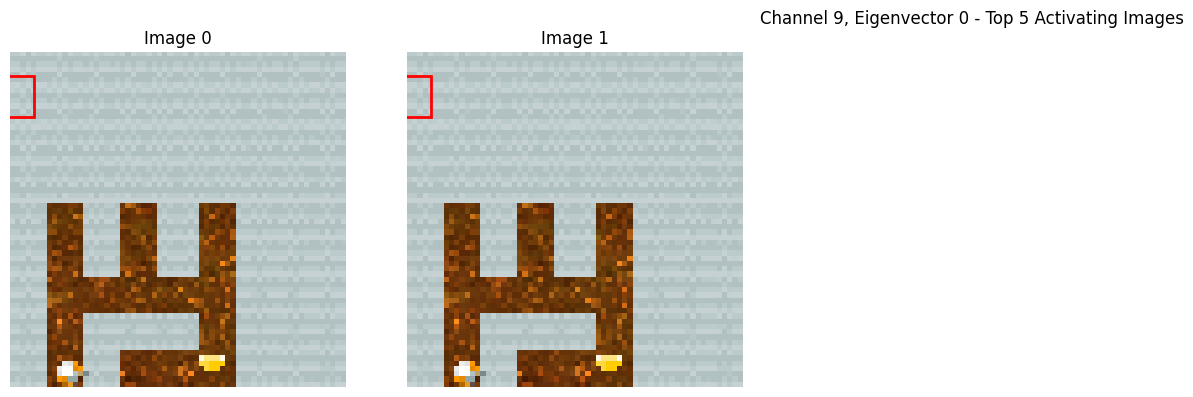

segment size,  8.0 8.0
segment size,  8.0 8.0


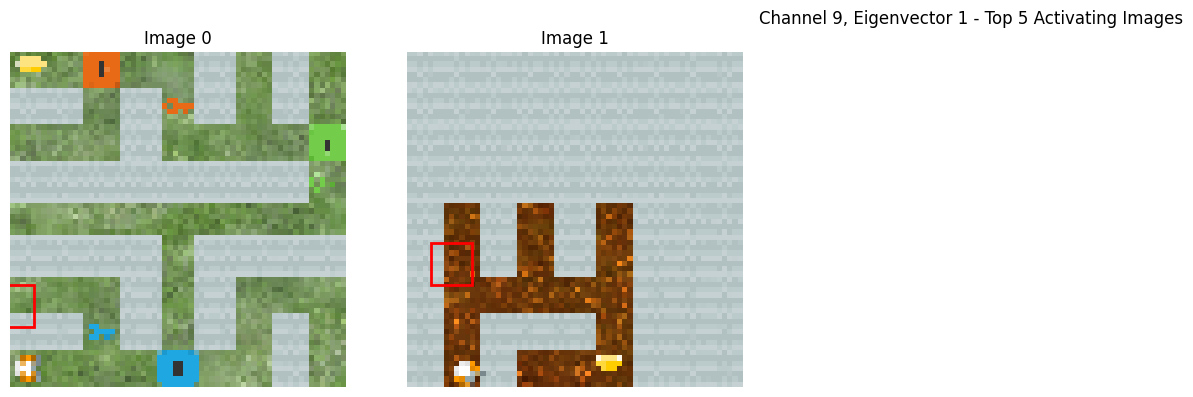

segment size,  8.0 8.0
segment size,  8.0 8.0


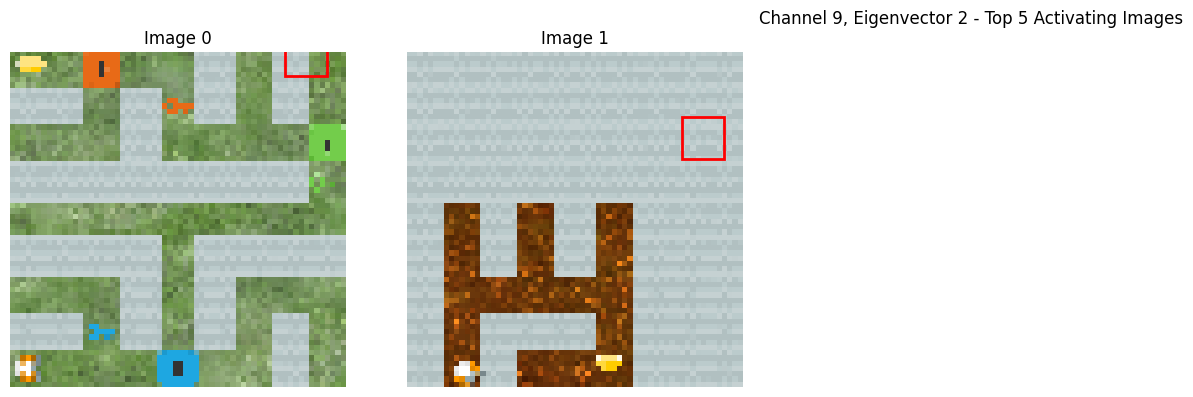

segment size,  8.0 8.0
segment size,  8.0 8.0


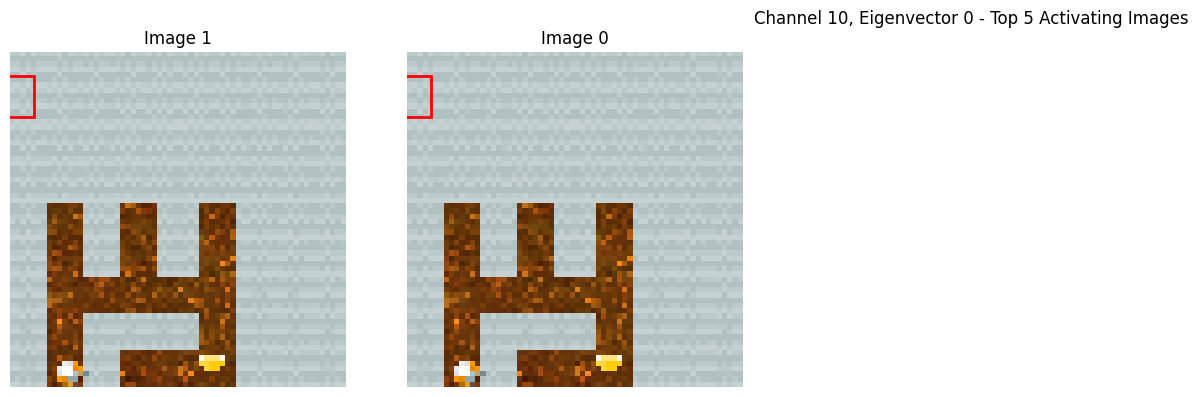

segment size,  8.0 8.0
segment size,  8.0 8.0


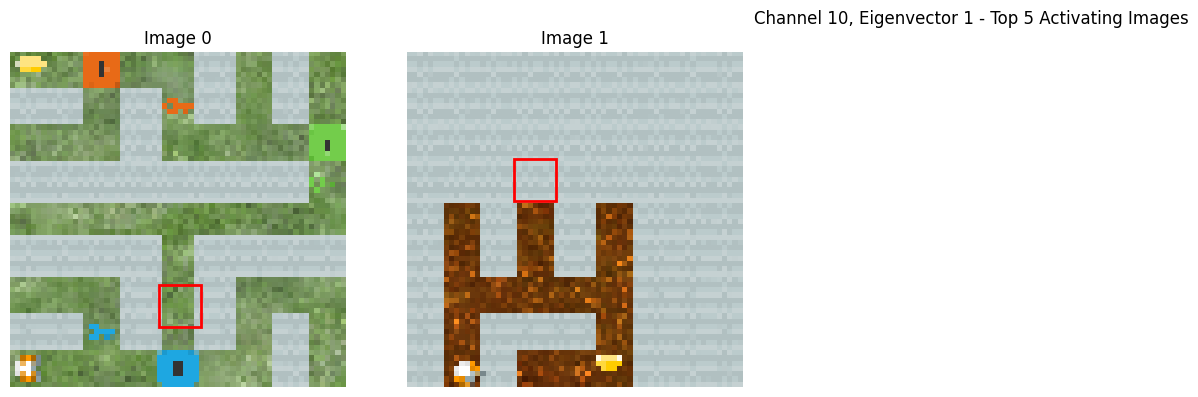

segment size,  8.0 8.0
segment size,  8.0 8.0


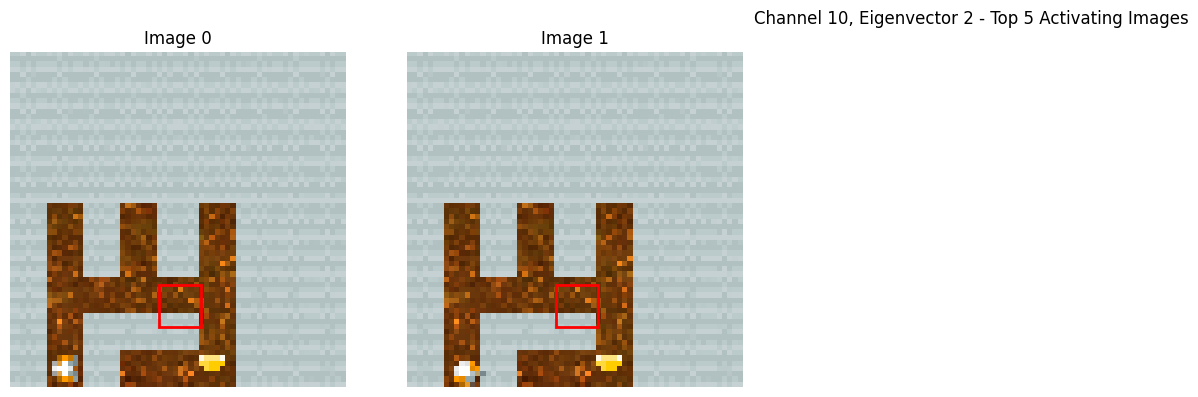

segment size,  8.0 8.0
segment size,  8.0 8.0


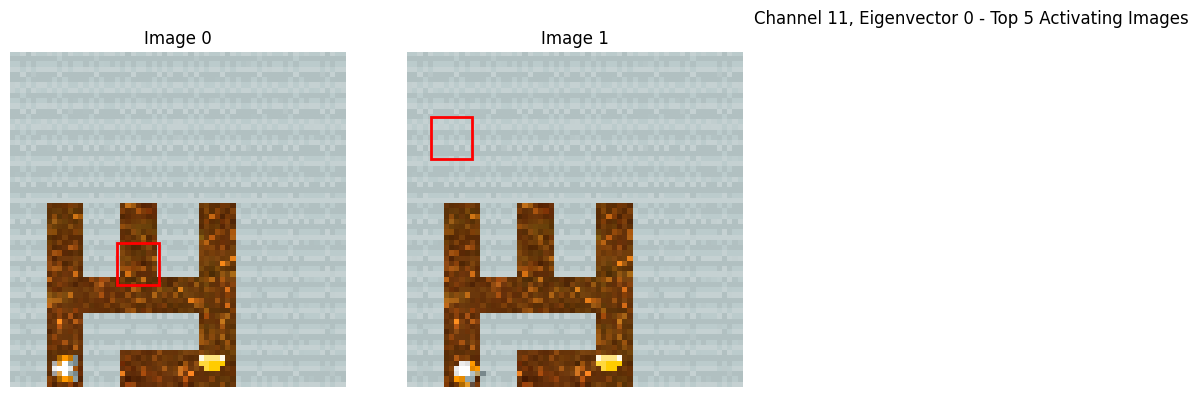

segment size,  8.0 8.0
segment size,  8.0 8.0


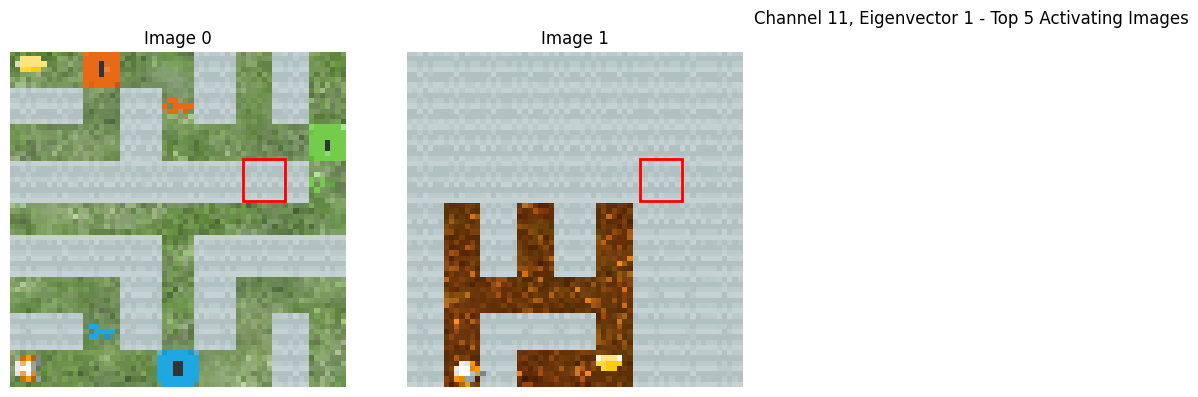

segment size,  8.0 8.0
segment size,  8.0 8.0


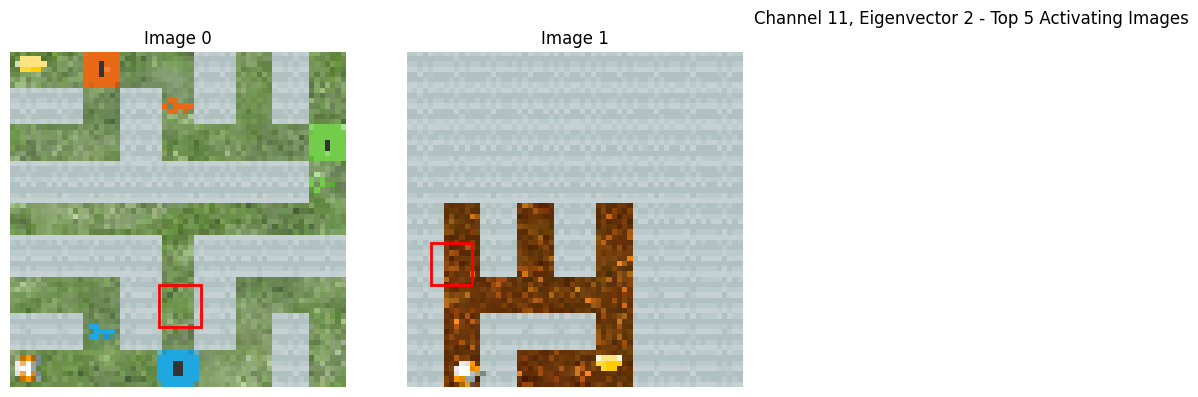

segment size,  8.0 8.0
segment size,  8.0 8.0


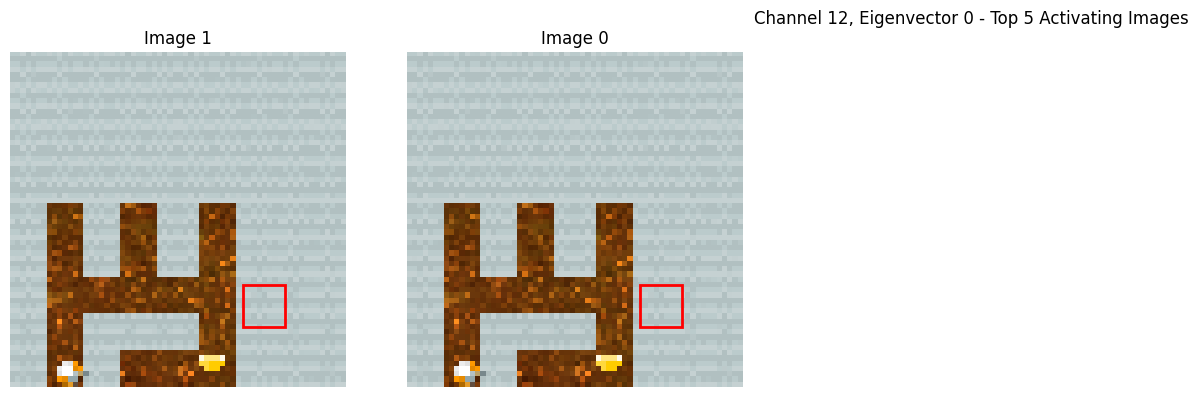

segment size,  8.0 8.0
segment size,  8.0 8.0


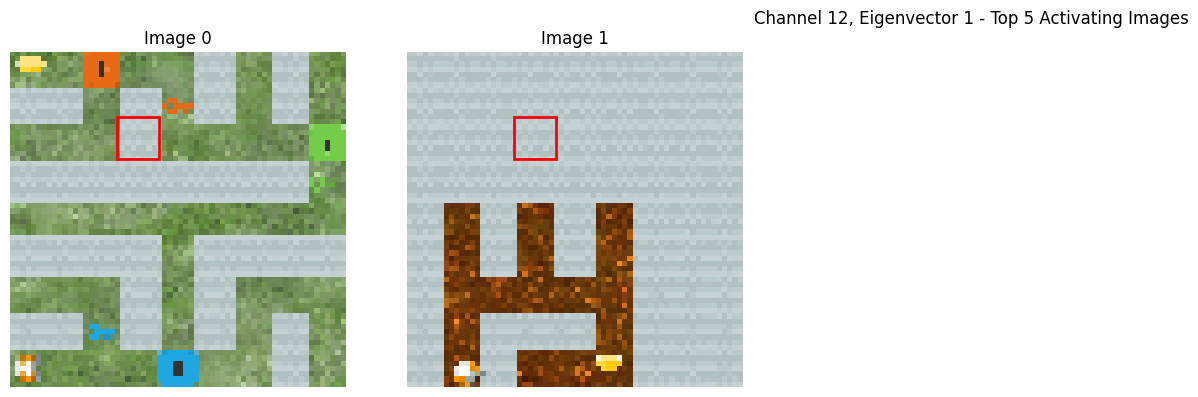

segment size,  8.0 8.0
segment size,  8.0 8.0


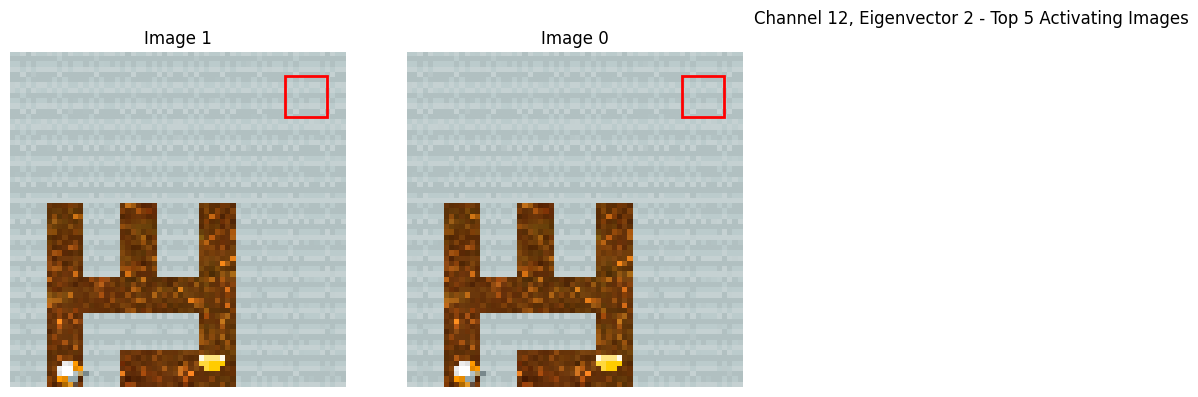

segment size,  8.0 8.0
segment size,  8.0 8.0


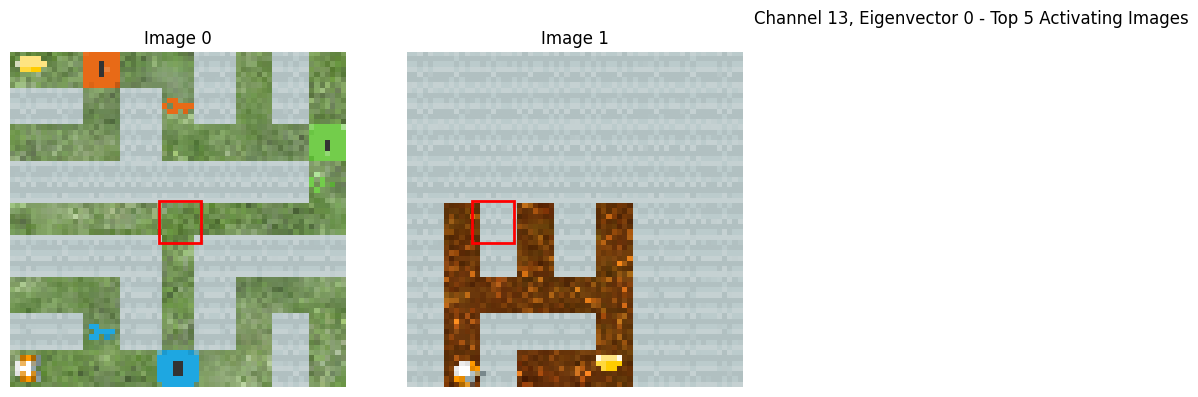

segment size,  8.0 8.0
segment size,  8.0 8.0


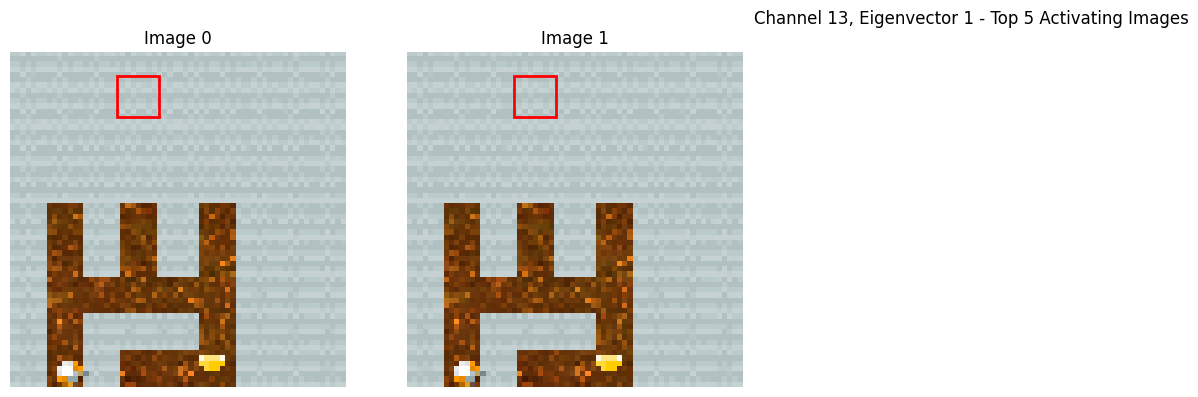

segment size,  8.0 8.0
segment size,  8.0 8.0


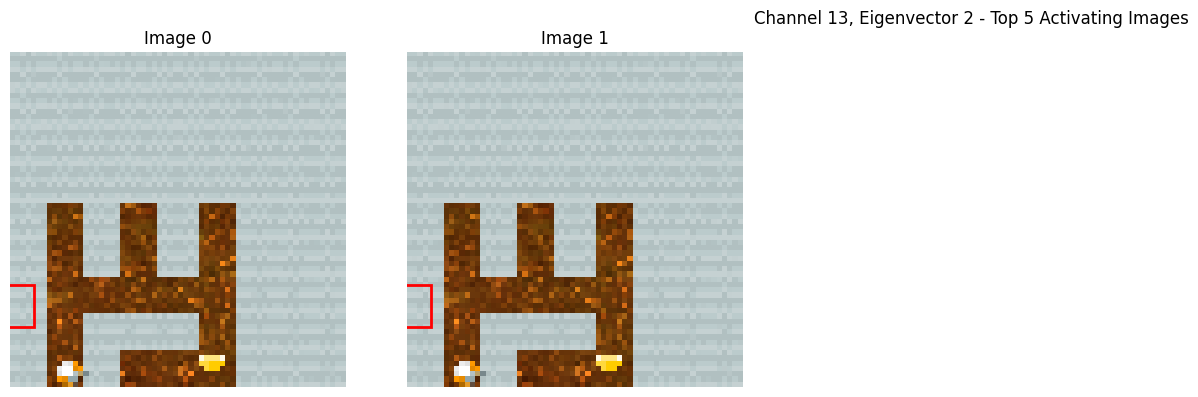

segment size,  8.0 8.0
segment size,  8.0 8.0


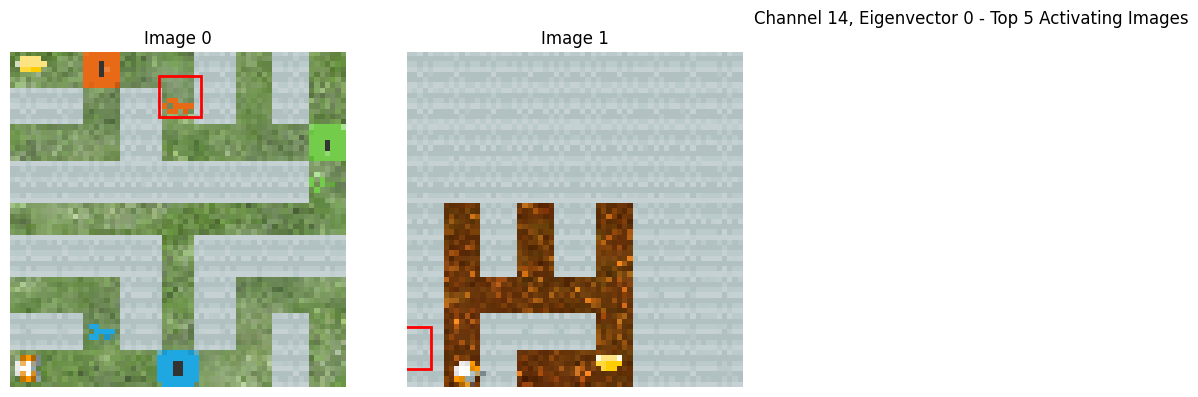

segment size,  8.0 8.0
segment size,  8.0 8.0


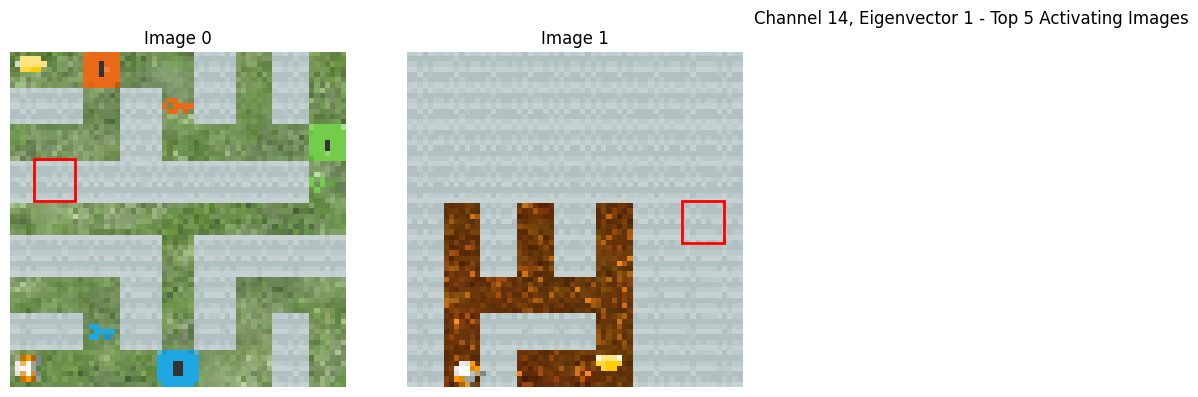

segment size,  8.0 8.0
segment size,  8.0 8.0


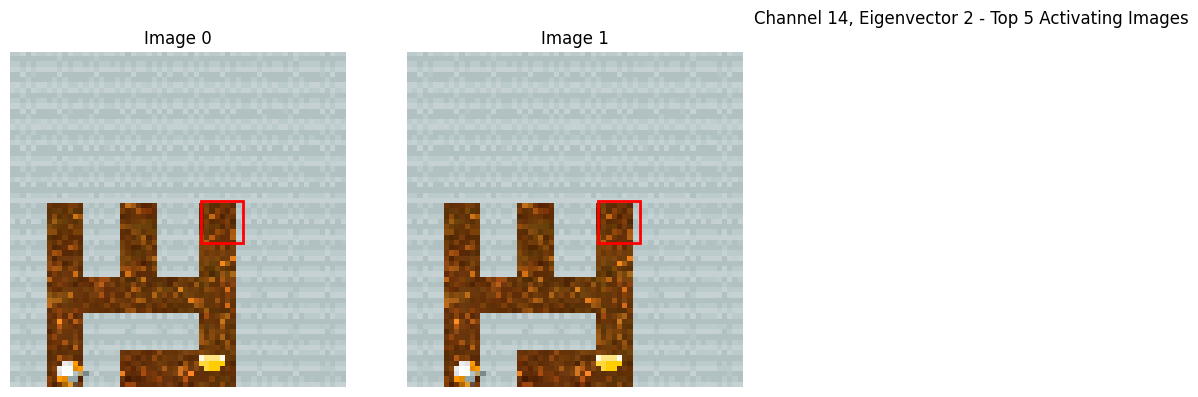

segment size,  8.0 8.0
segment size,  8.0 8.0


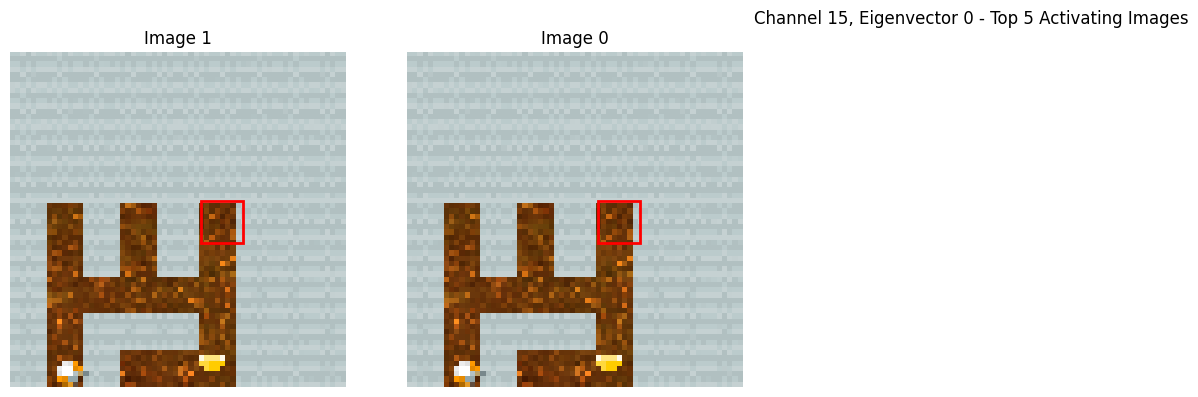

segment size,  8.0 8.0
segment size,  8.0 8.0


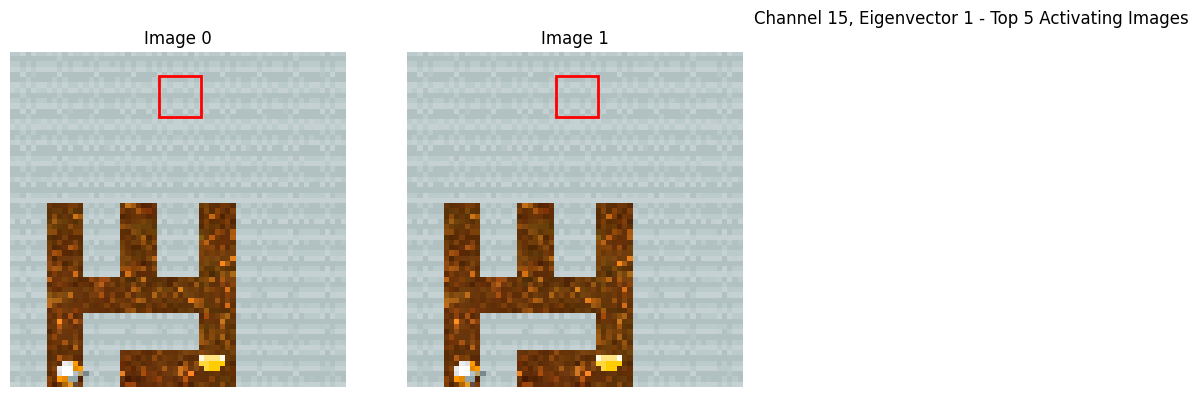

segment size,  8.0 8.0
segment size,  8.0 8.0


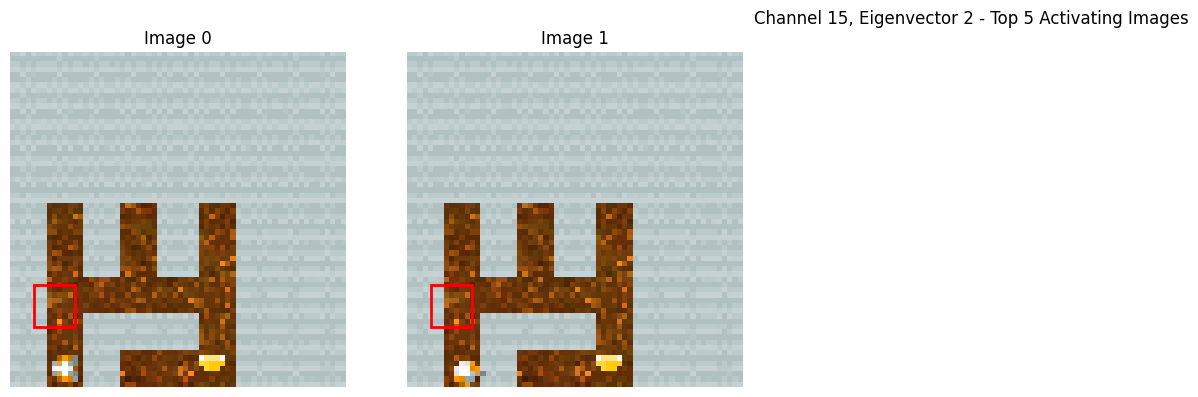

segment size,  8.0 8.0
segment size,  8.0 8.0


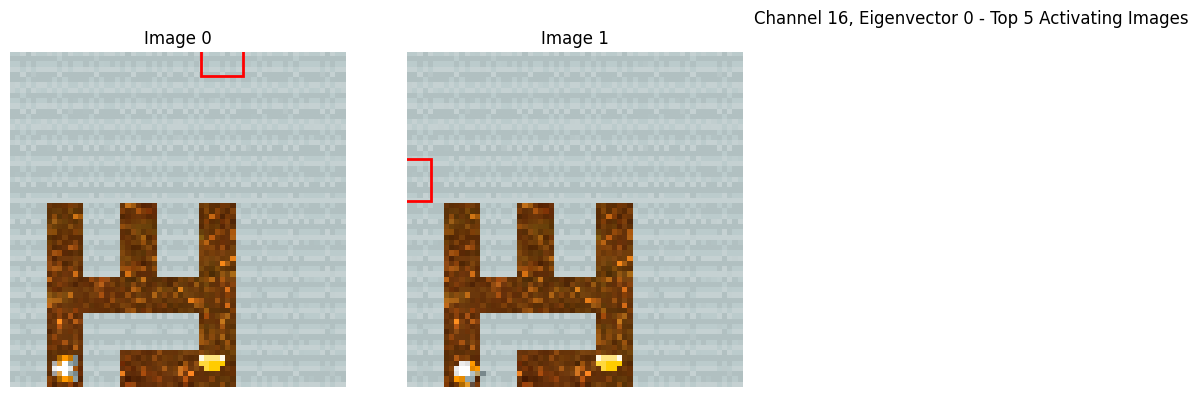

segment size,  8.0 8.0
segment size,  8.0 8.0


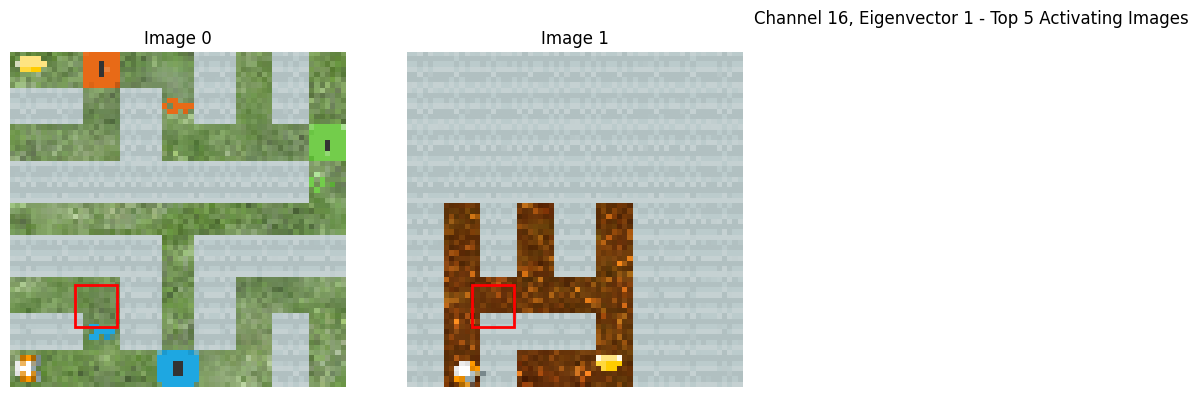

segment size,  8.0 8.0
segment size,  8.0 8.0


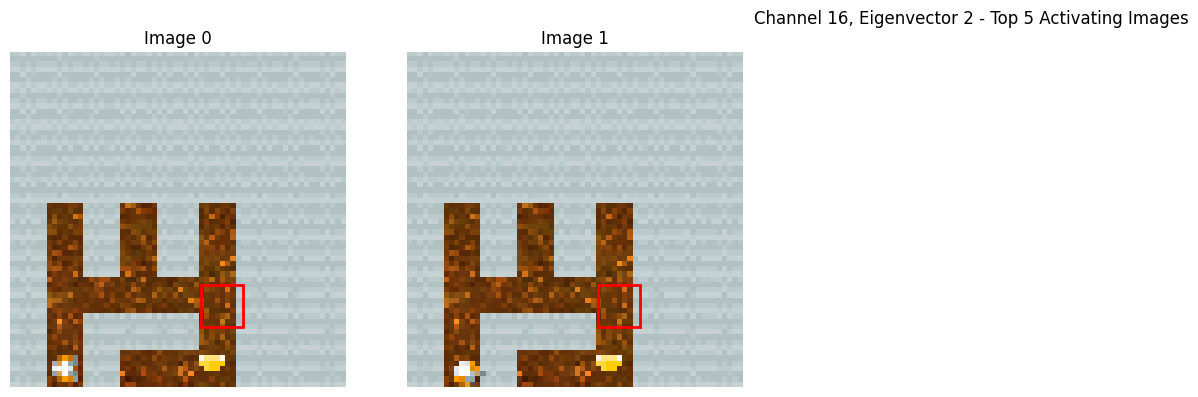

segment size,  8.0 8.0
segment size,  8.0 8.0


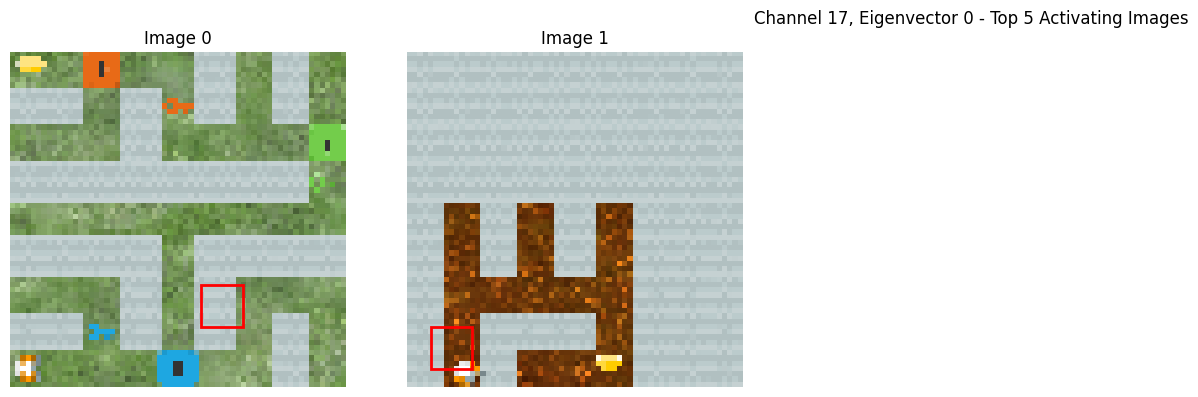

segment size,  8.0 8.0
segment size,  8.0 8.0


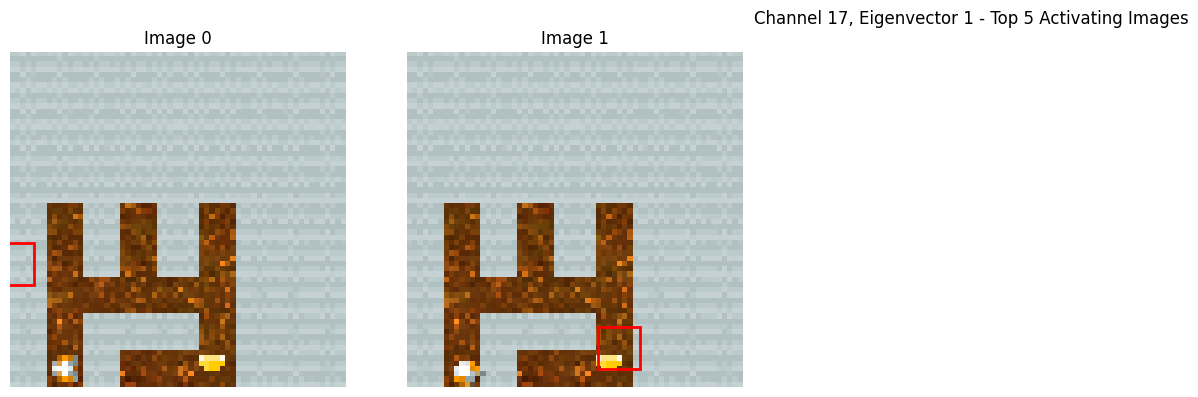

segment size,  8.0 8.0
segment size,  8.0 8.0


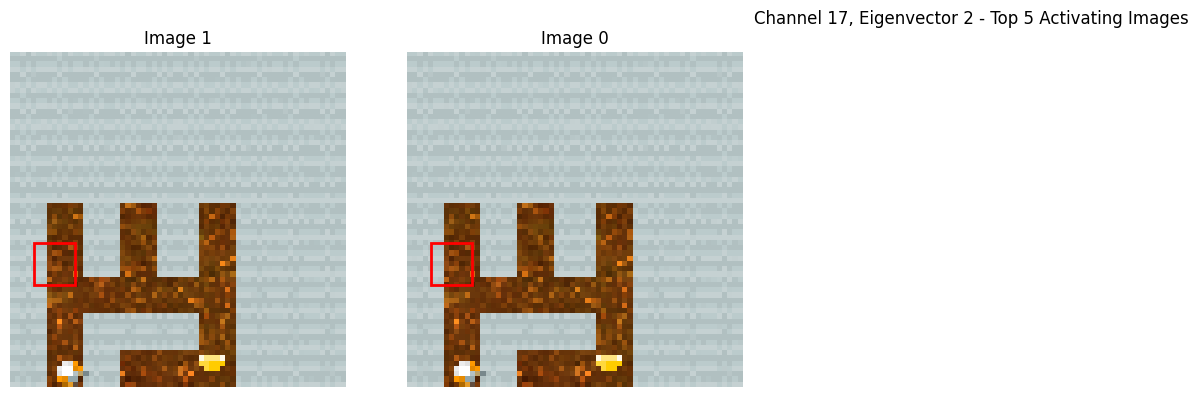

segment size,  8.0 8.0
segment size,  8.0 8.0


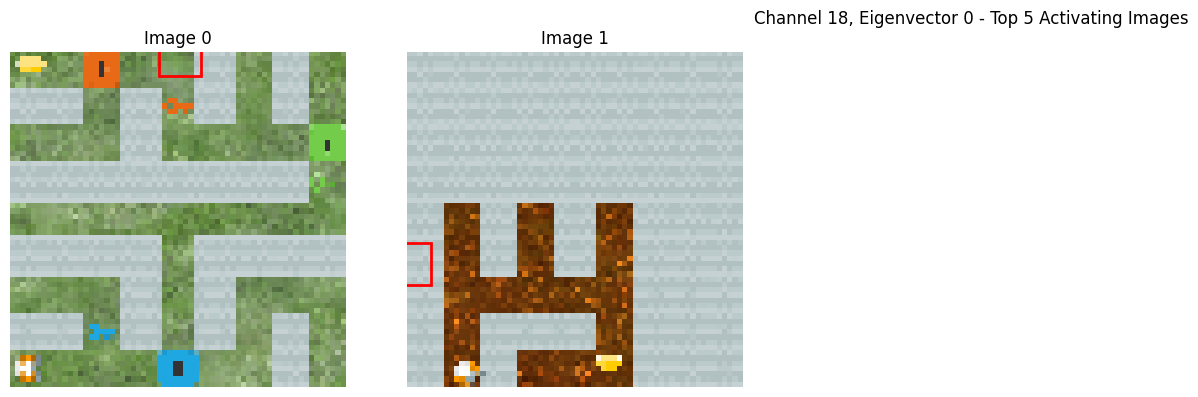

segment size,  8.0 8.0
segment size,  8.0 8.0


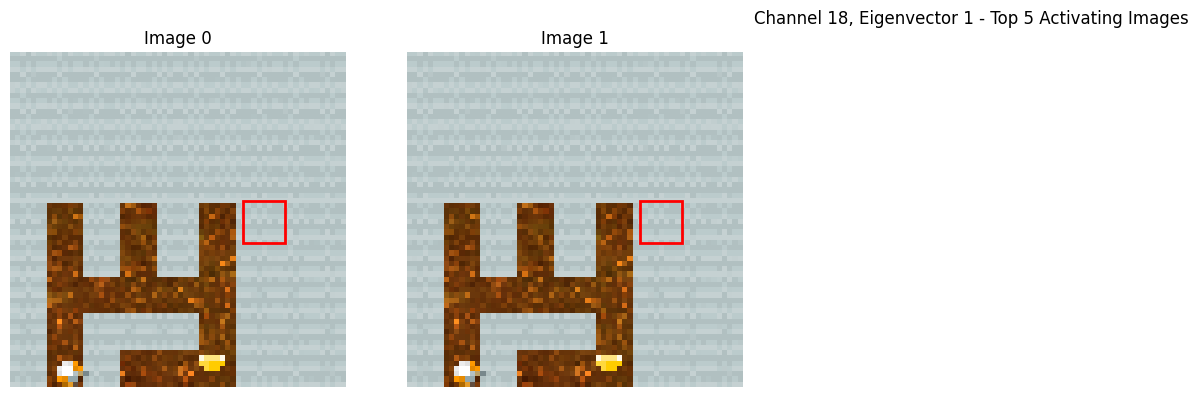

segment size,  8.0 8.0
segment size,  8.0 8.0


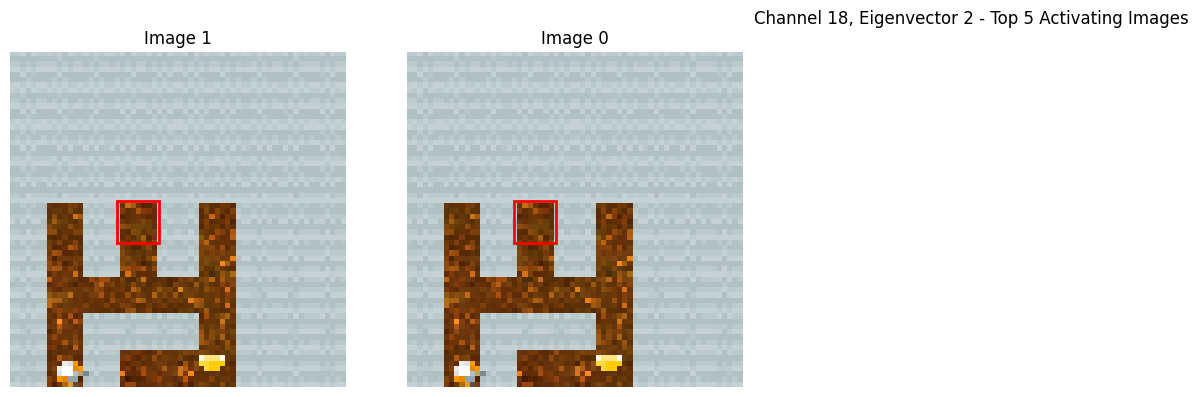

segment size,  8.0 8.0
segment size,  8.0 8.0


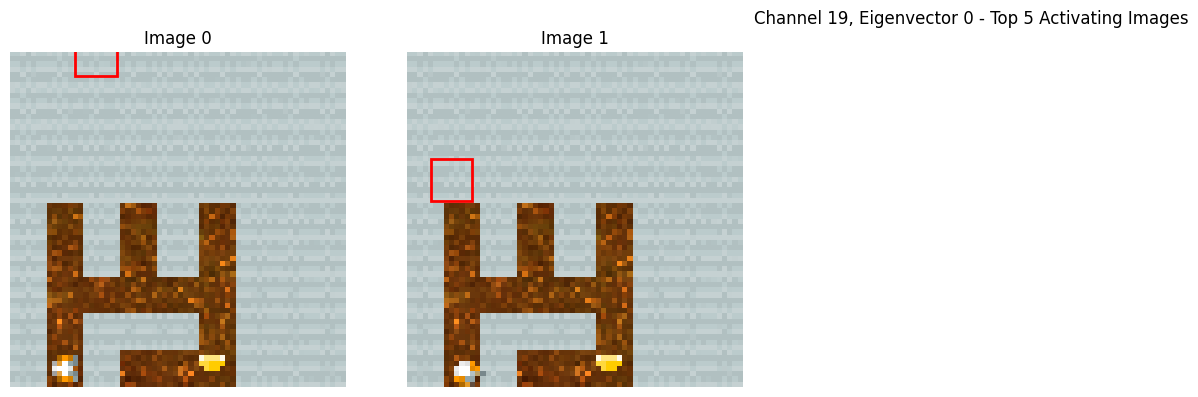

segment size,  8.0 8.0
segment size,  8.0 8.0


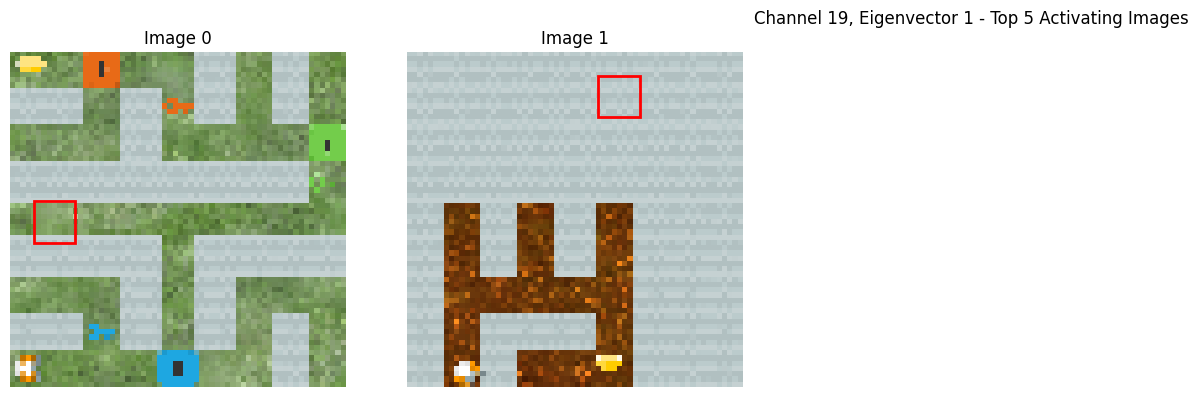

segment size,  8.0 8.0
segment size,  8.0 8.0


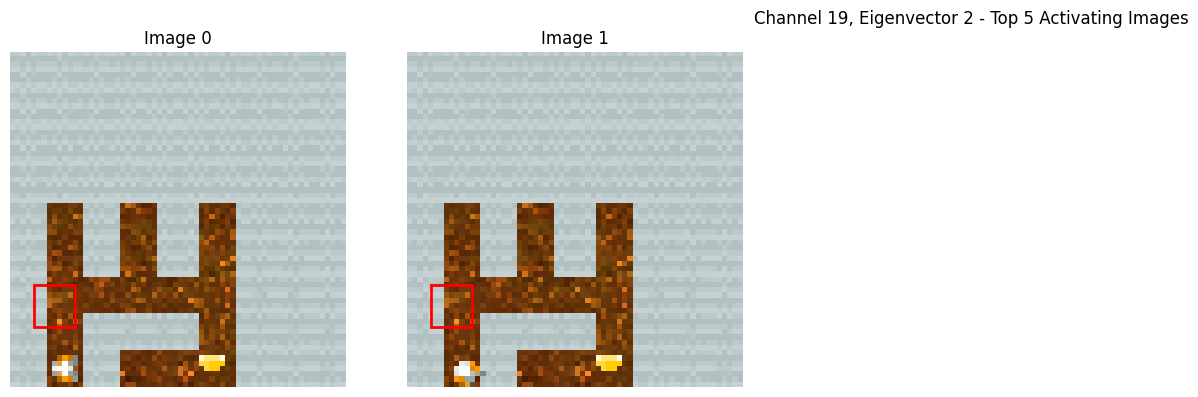

segment size,  8.0 8.0
segment size,  8.0 8.0


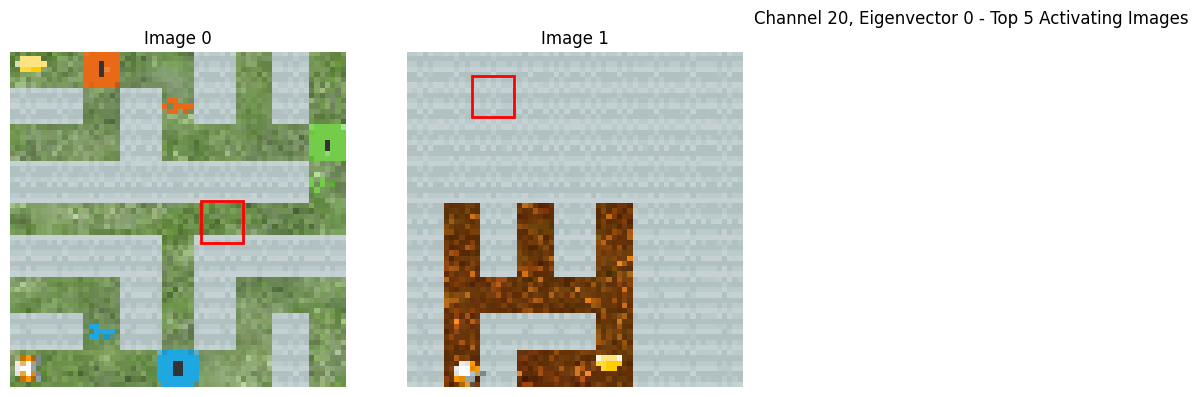

segment size,  8.0 8.0
segment size,  8.0 8.0


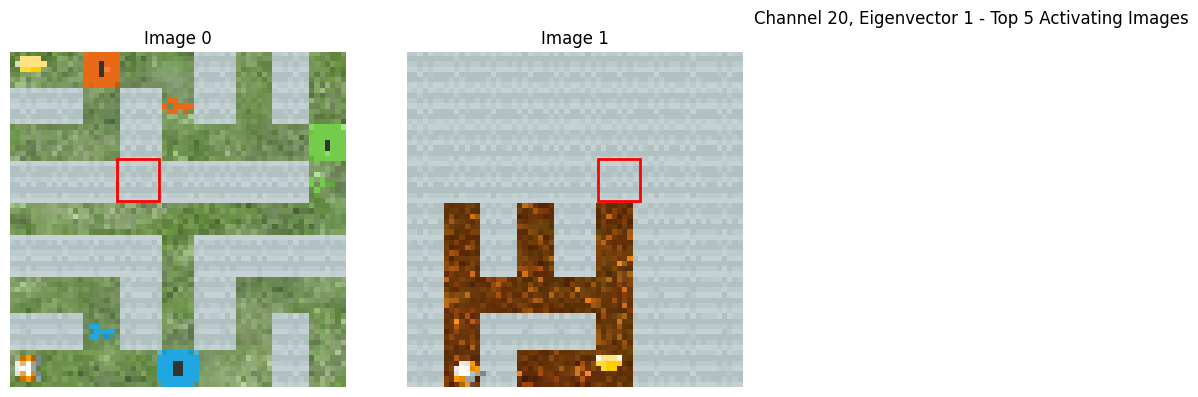

segment size,  8.0 8.0
segment size,  8.0 8.0


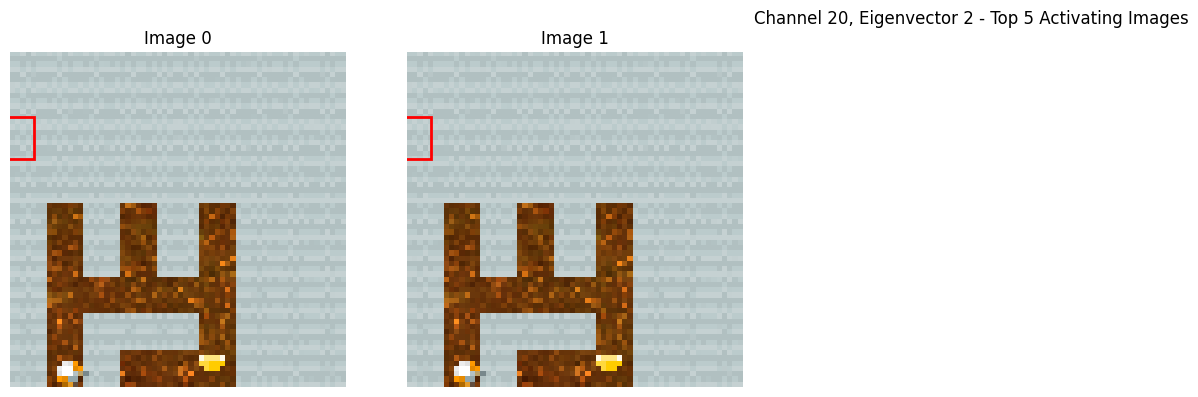

segment size,  8.0 8.0
segment size,  8.0 8.0


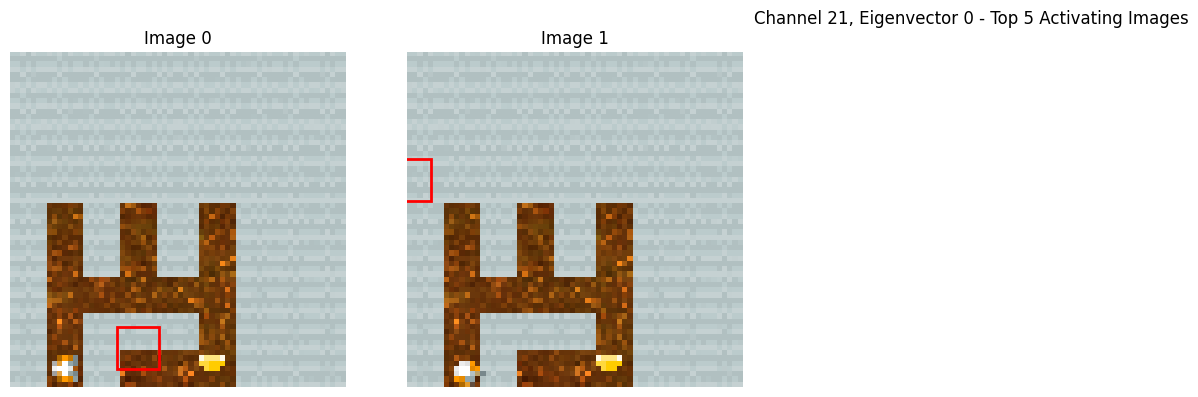

segment size,  8.0 8.0
segment size,  8.0 8.0


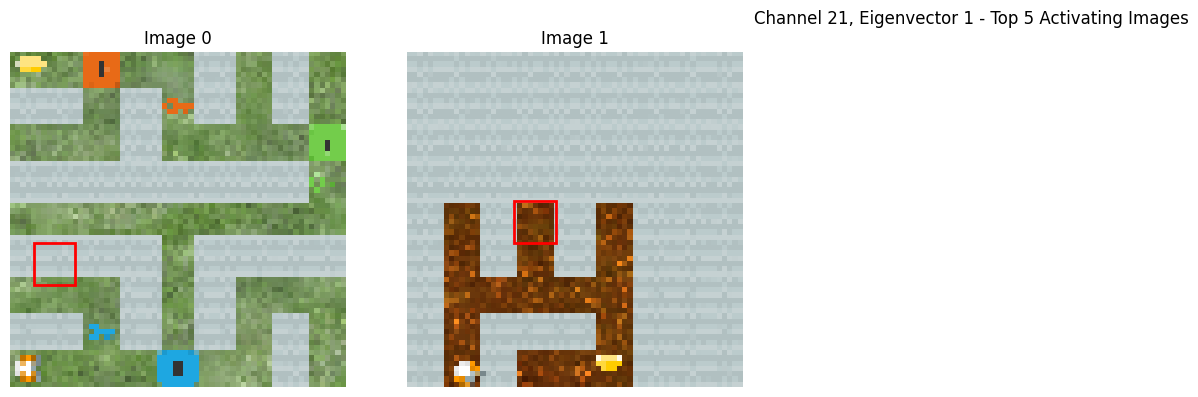

segment size,  8.0 8.0
segment size,  8.0 8.0


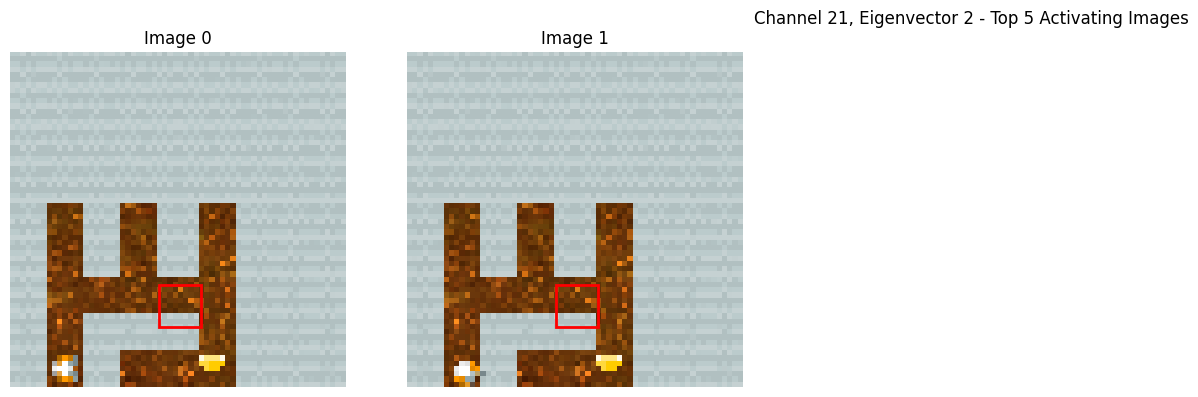

segment size,  8.0 8.0
segment size,  8.0 8.0


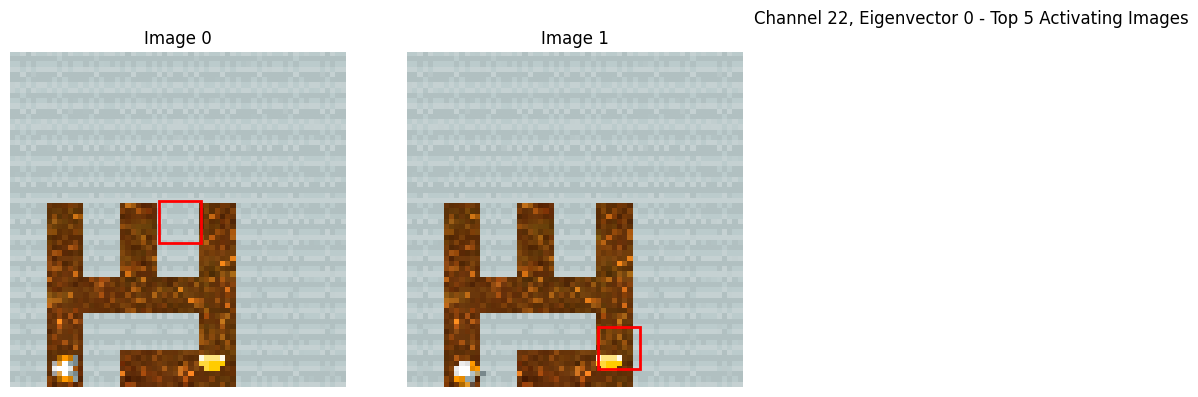

segment size,  8.0 8.0
segment size,  8.0 8.0


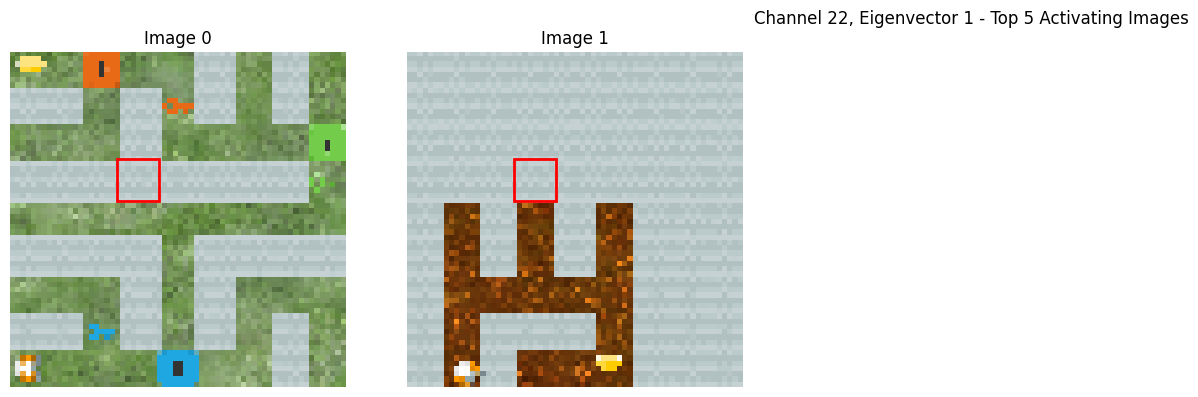

segment size,  8.0 8.0
segment size,  8.0 8.0


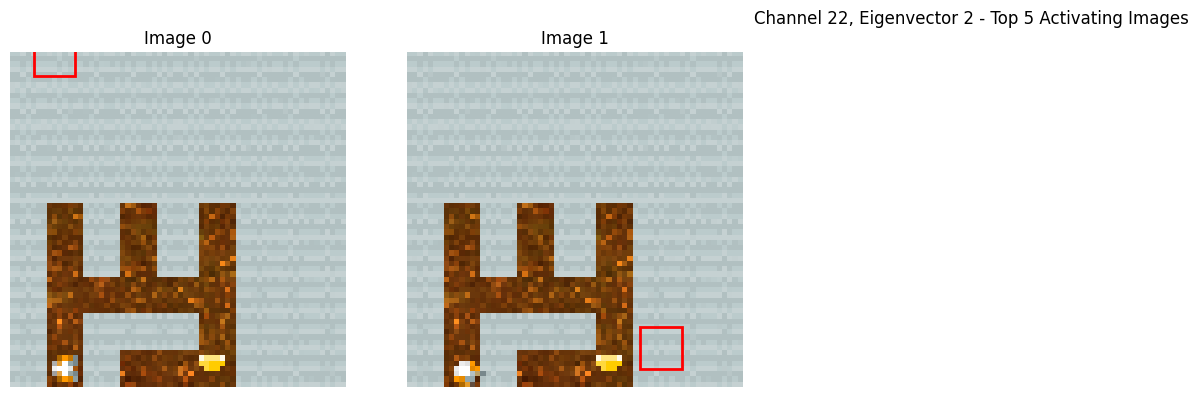

segment size,  8.0 8.0
segment size,  8.0 8.0


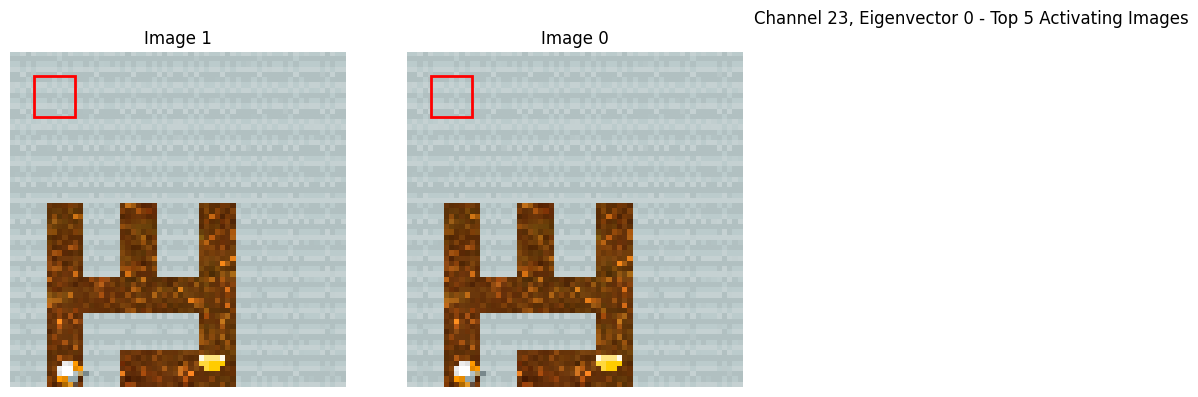

segment size,  8.0 8.0
segment size,  8.0 8.0


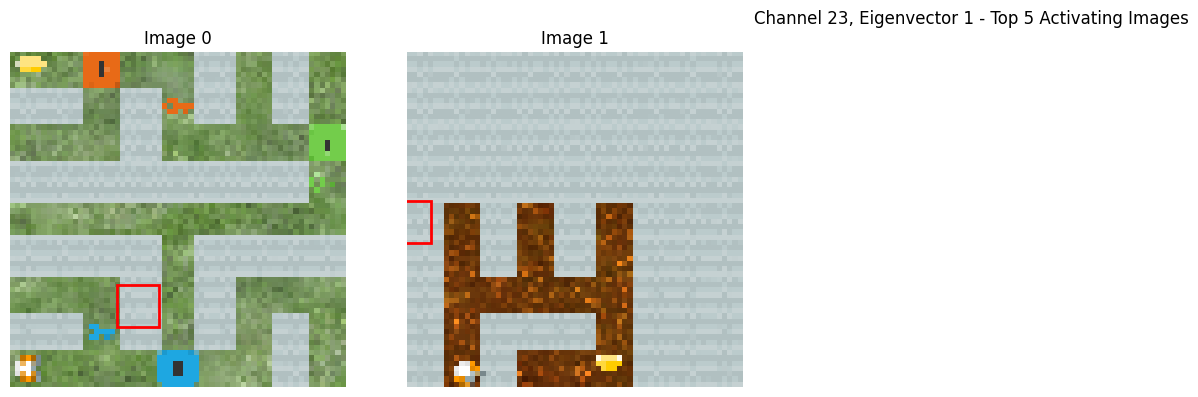

segment size,  8.0 8.0
segment size,  8.0 8.0


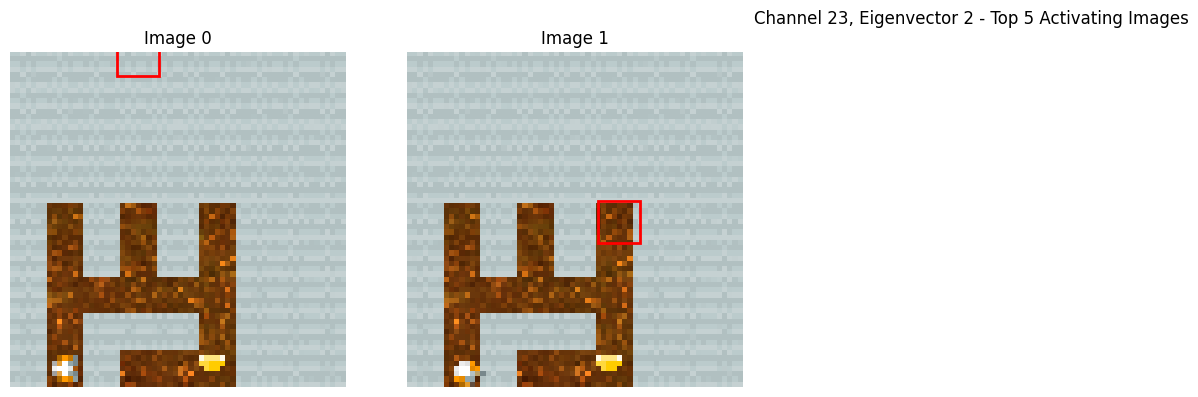

segment size,  8.0 8.0
segment size,  8.0 8.0


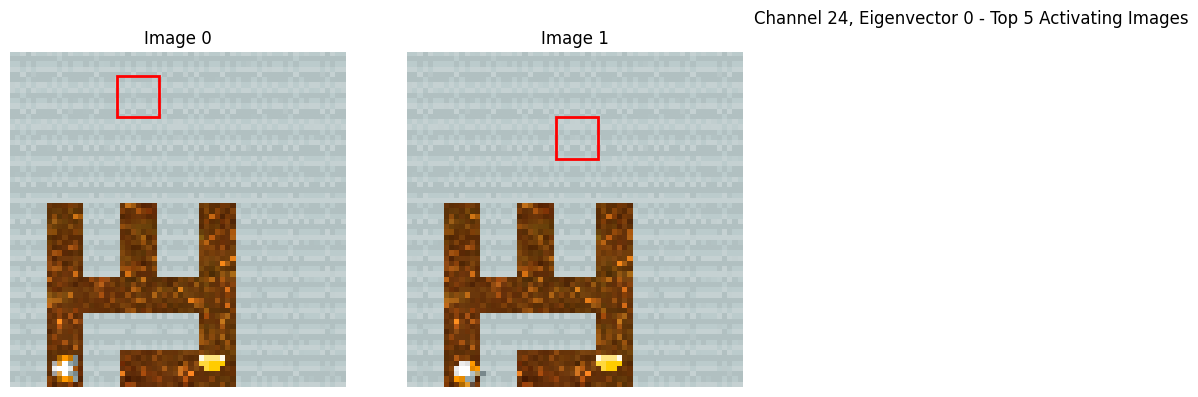

segment size,  8.0 8.0
segment size,  8.0 8.0


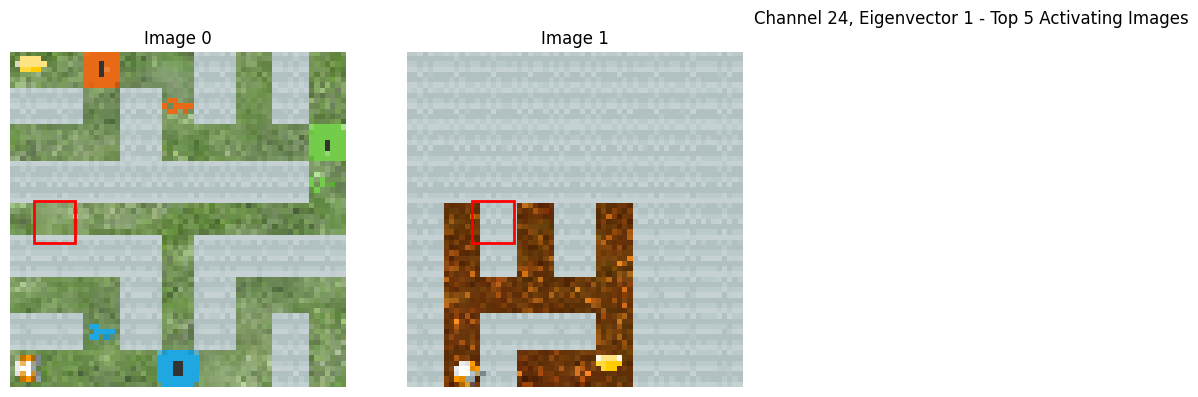

segment size,  8.0 8.0
segment size,  8.0 8.0


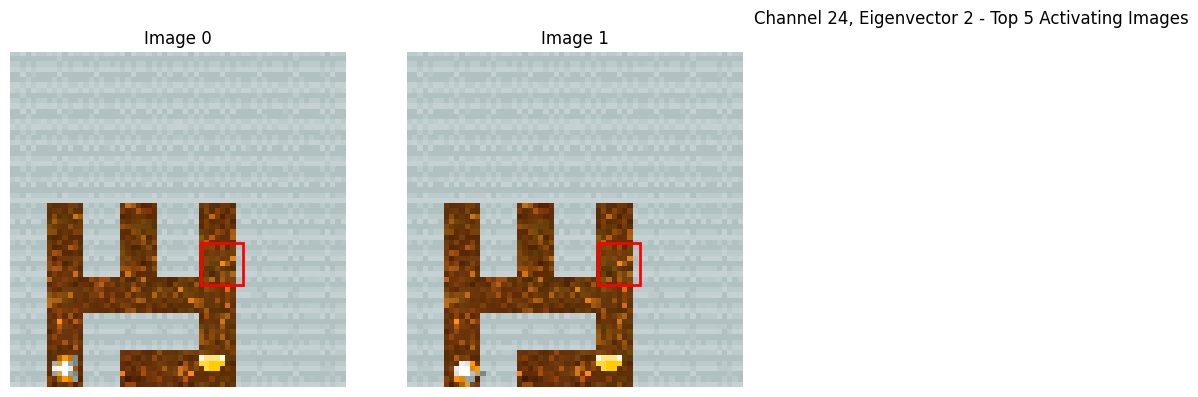

segment size,  8.0 8.0
segment size,  8.0 8.0


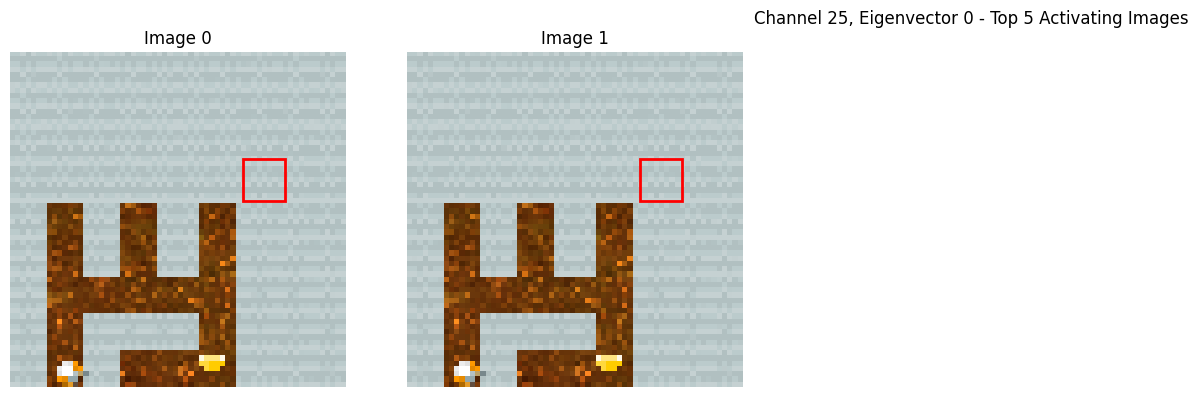

segment size,  8.0 8.0
segment size,  8.0 8.0


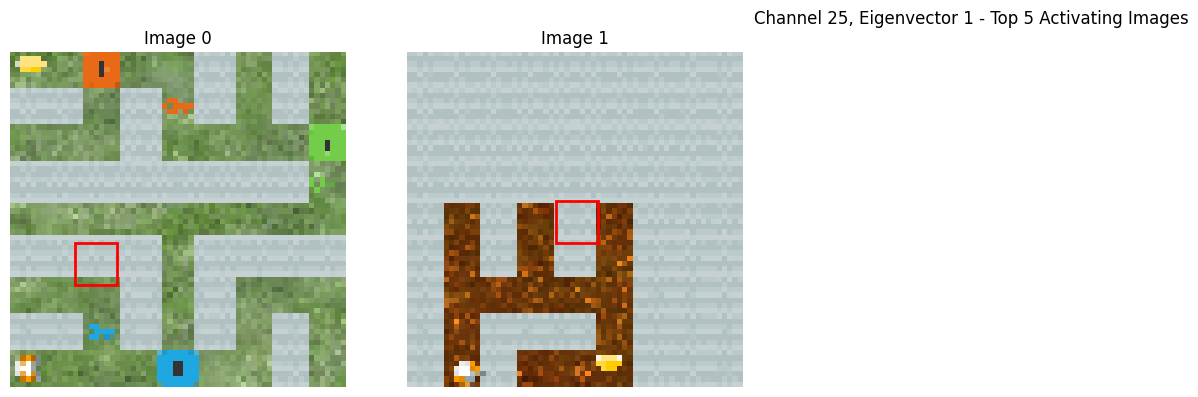

segment size,  8.0 8.0
segment size,  8.0 8.0


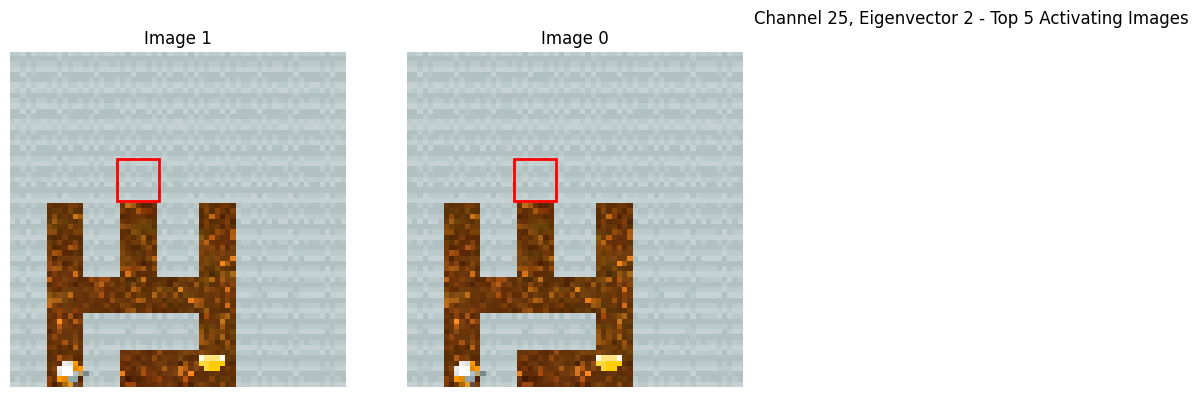

segment size,  8.0 8.0
segment size,  8.0 8.0


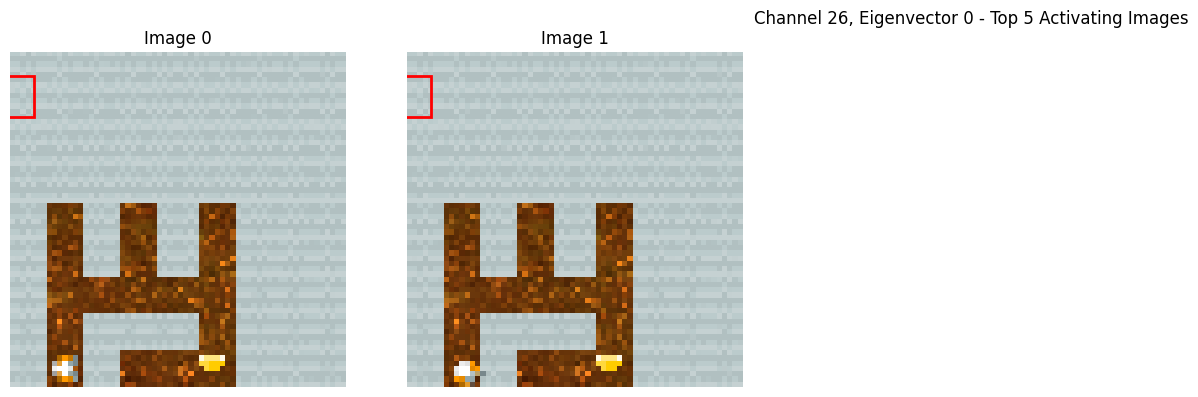

segment size,  8.0 8.0
segment size,  8.0 8.0


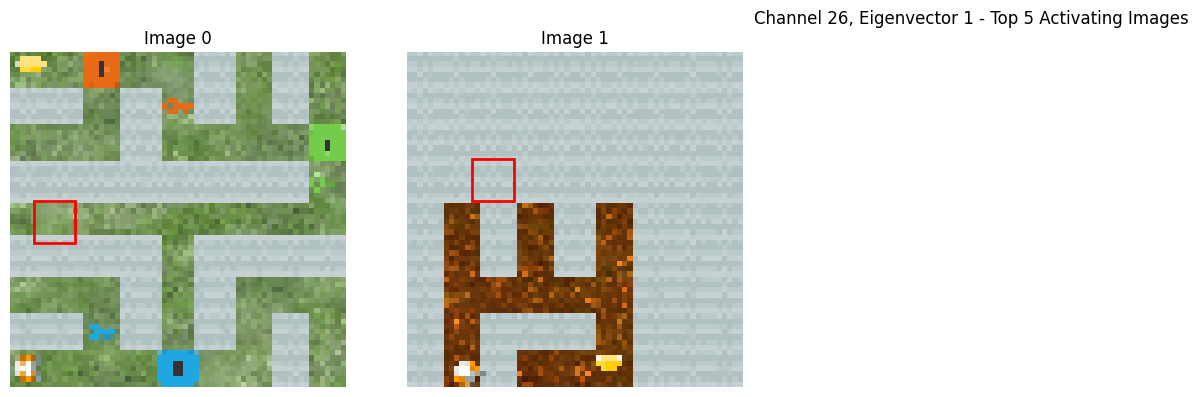

segment size,  8.0 8.0
segment size,  8.0 8.0


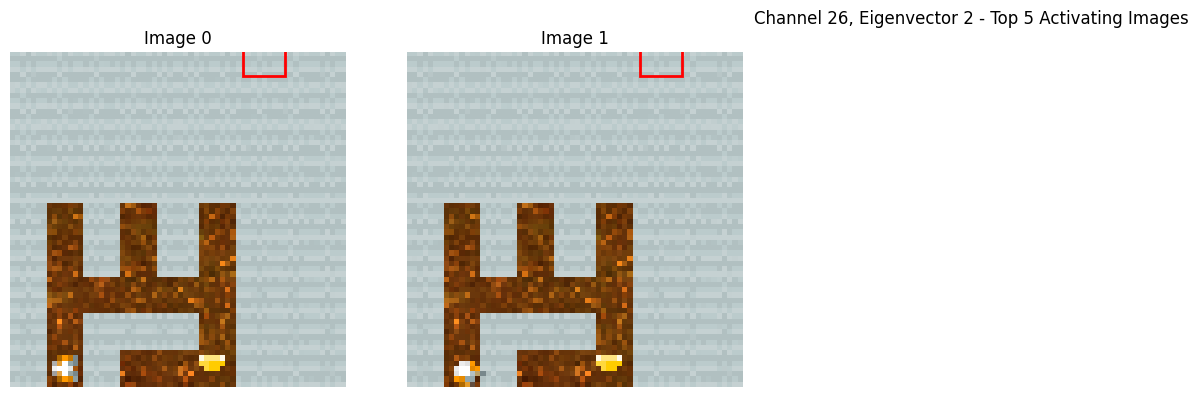

segment size,  8.0 8.0
segment size,  8.0 8.0


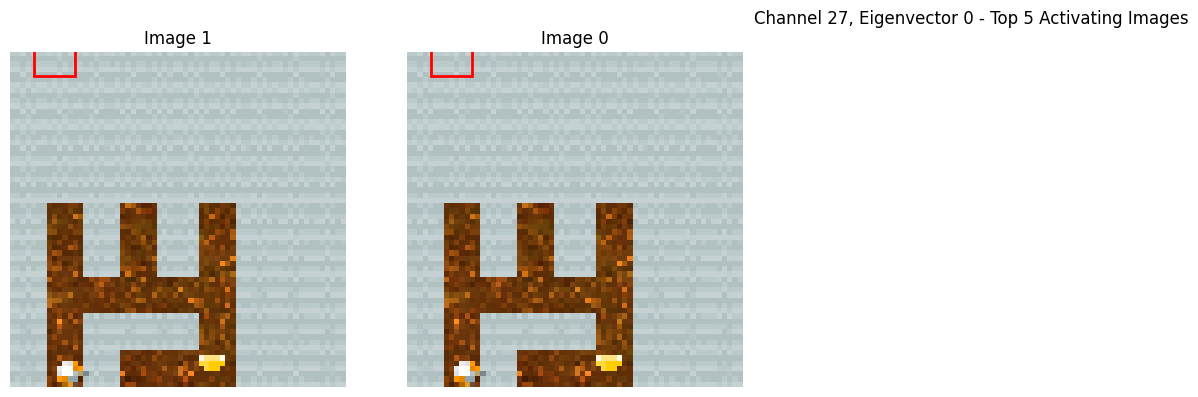

segment size,  8.0 8.0
segment size,  8.0 8.0


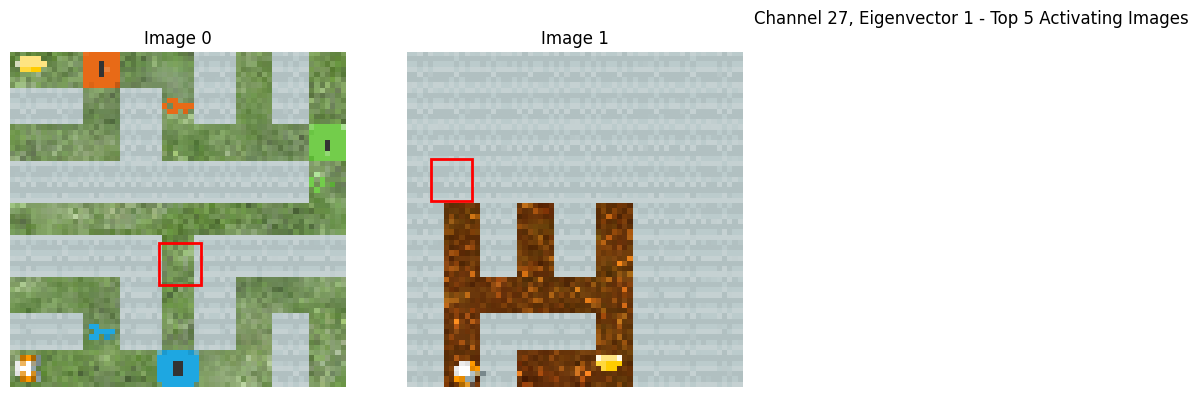

segment size,  8.0 8.0
segment size,  8.0 8.0


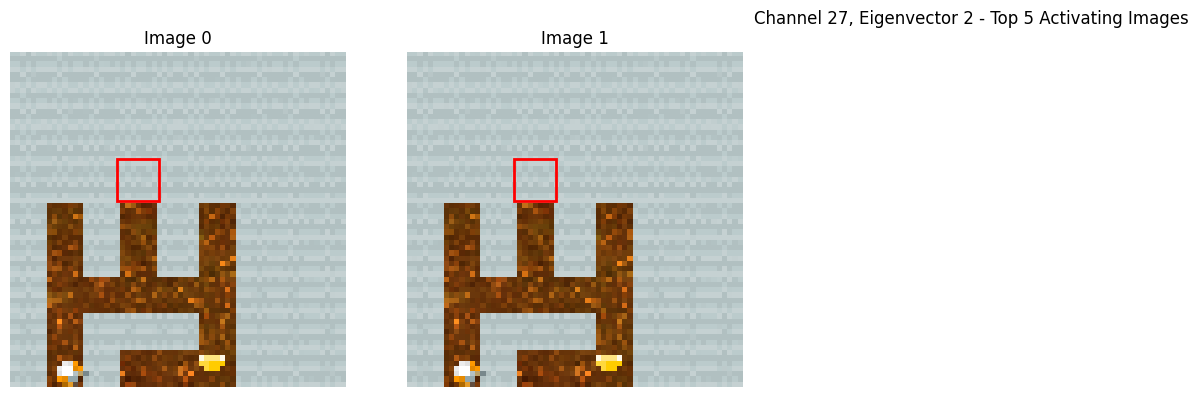

segment size,  8.0 8.0
segment size,  8.0 8.0


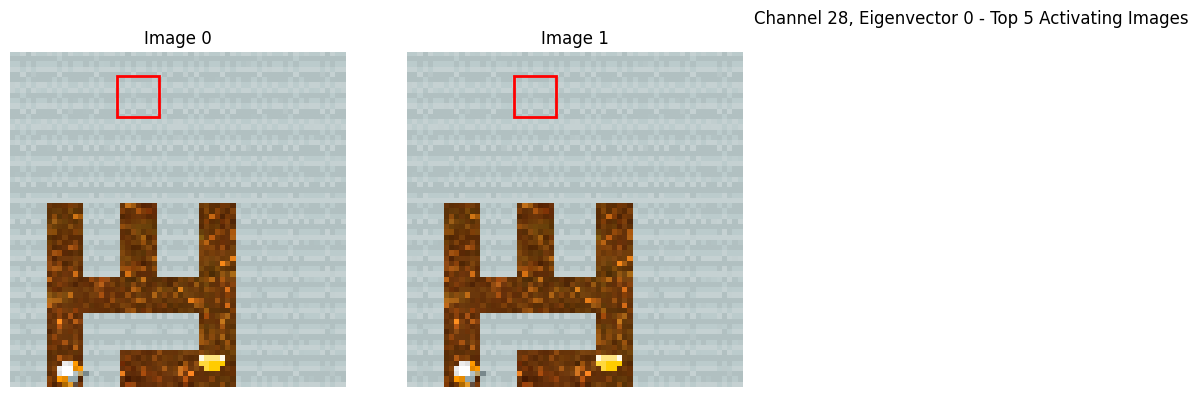

segment size,  8.0 8.0
segment size,  8.0 8.0


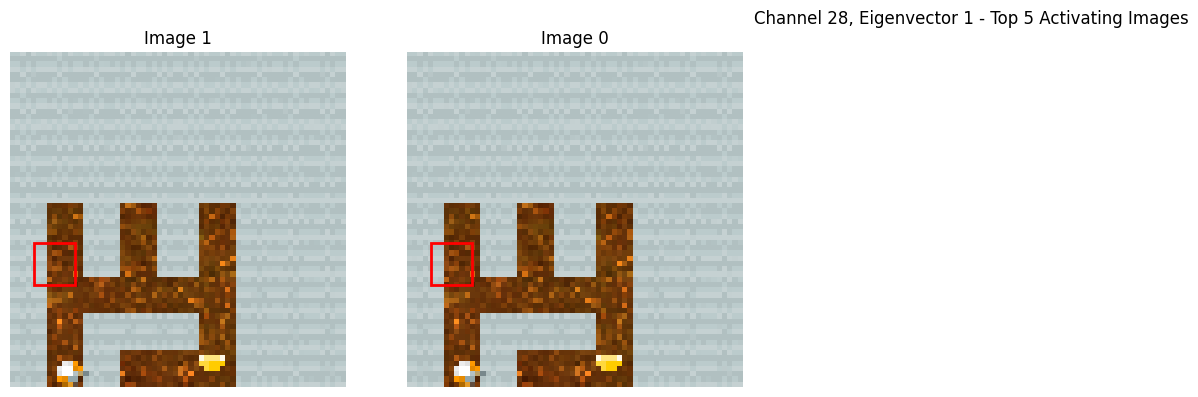

segment size,  8.0 8.0
segment size,  8.0 8.0


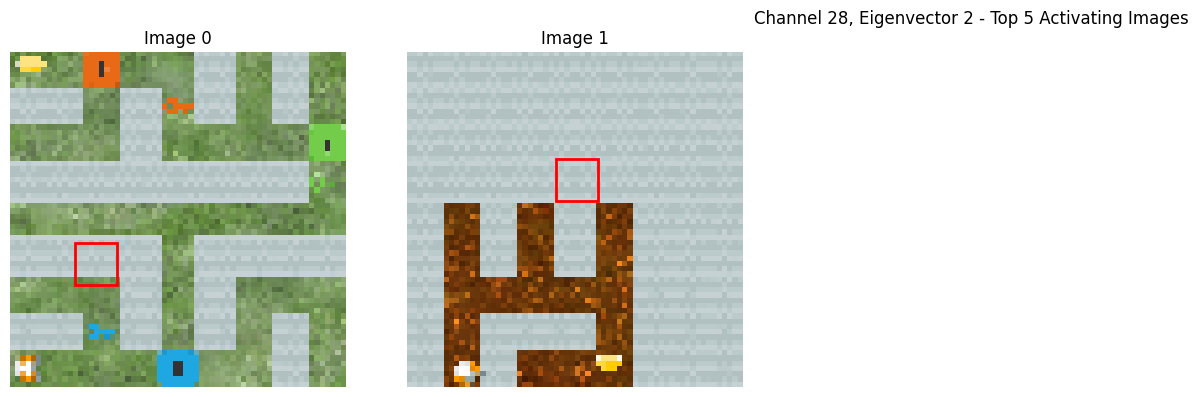

segment size,  8.0 8.0
segment size,  8.0 8.0


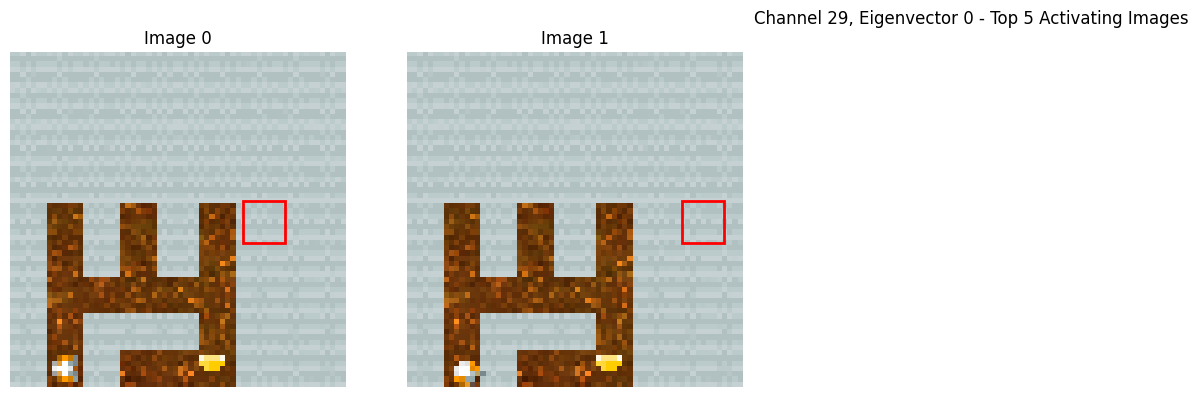

segment size,  8.0 8.0
segment size,  8.0 8.0


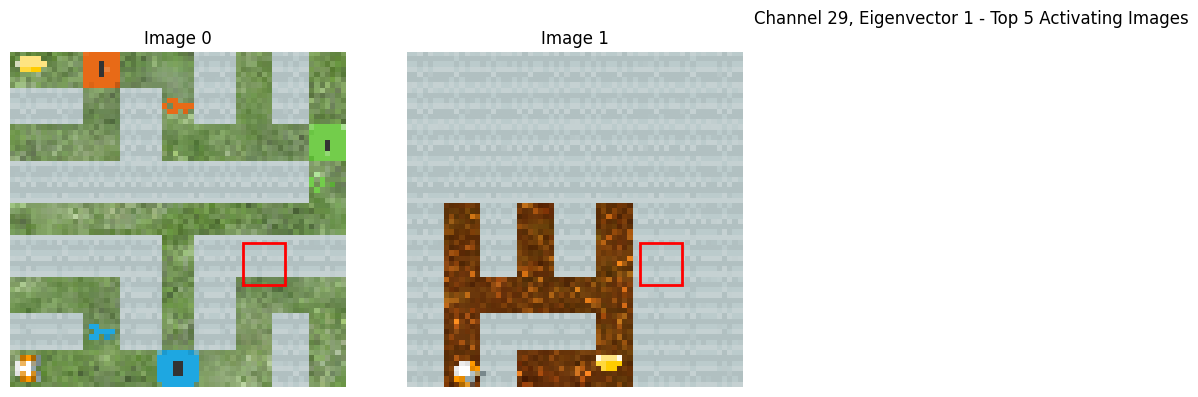

segment size,  8.0 8.0
segment size,  8.0 8.0


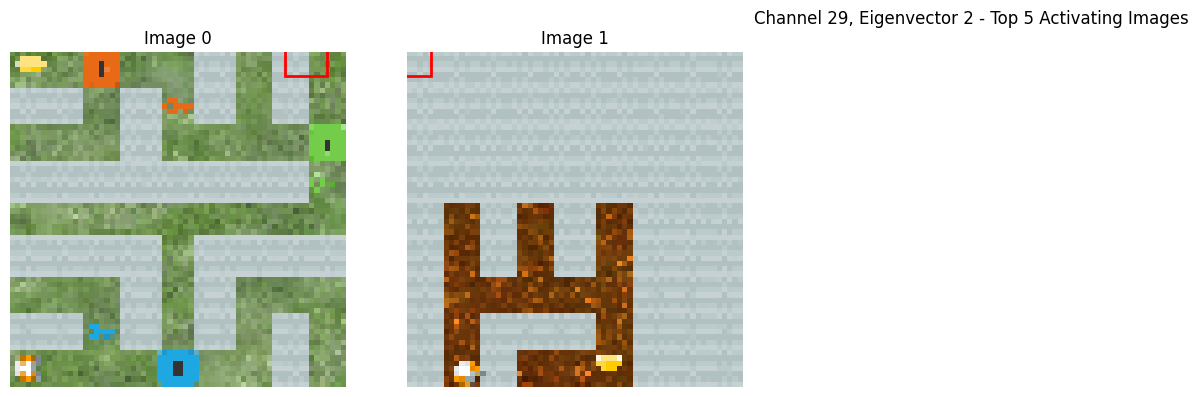

segment size,  8.0 8.0
segment size,  8.0 8.0


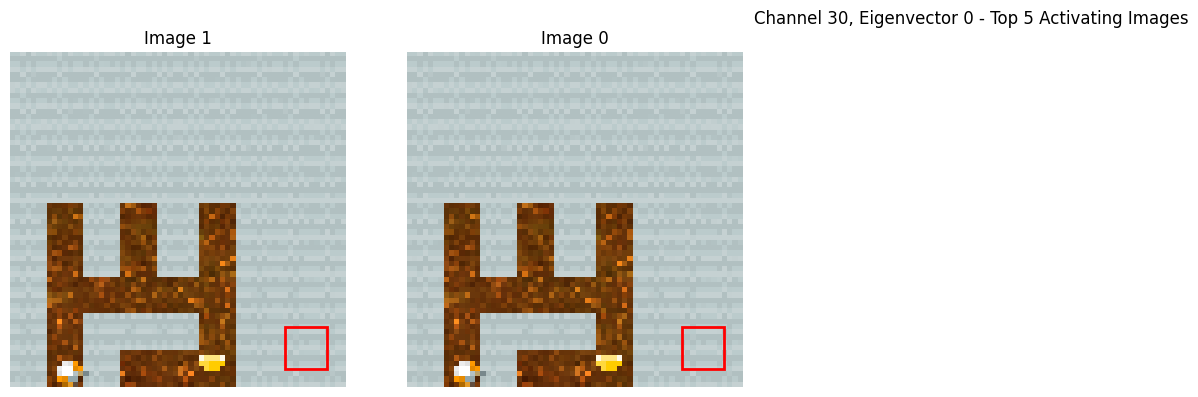

segment size,  8.0 8.0
segment size,  8.0 8.0


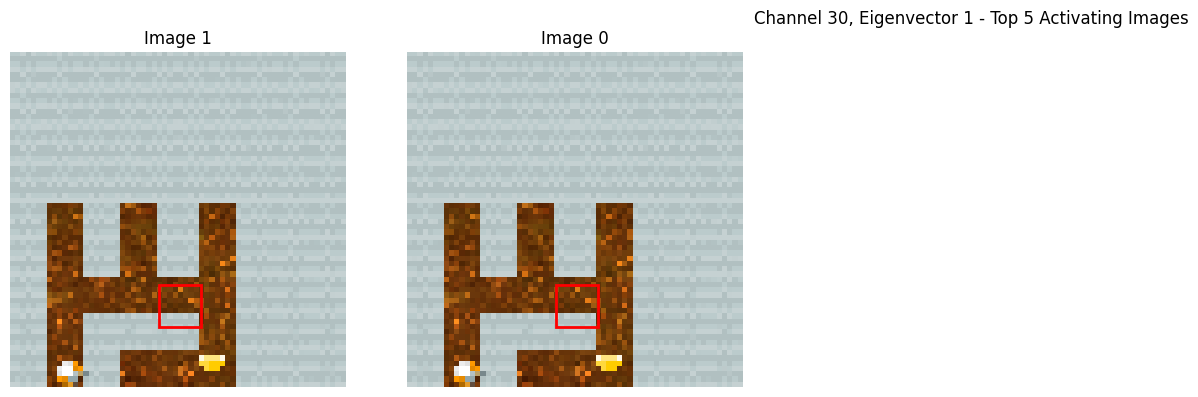

segment size,  8.0 8.0
segment size,  8.0 8.0


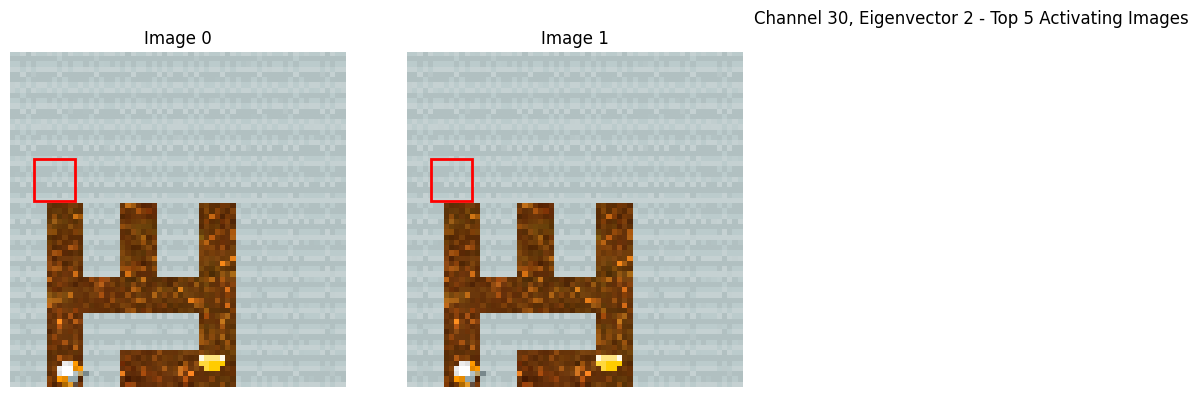

segment size,  8.0 8.0
segment size,  8.0 8.0


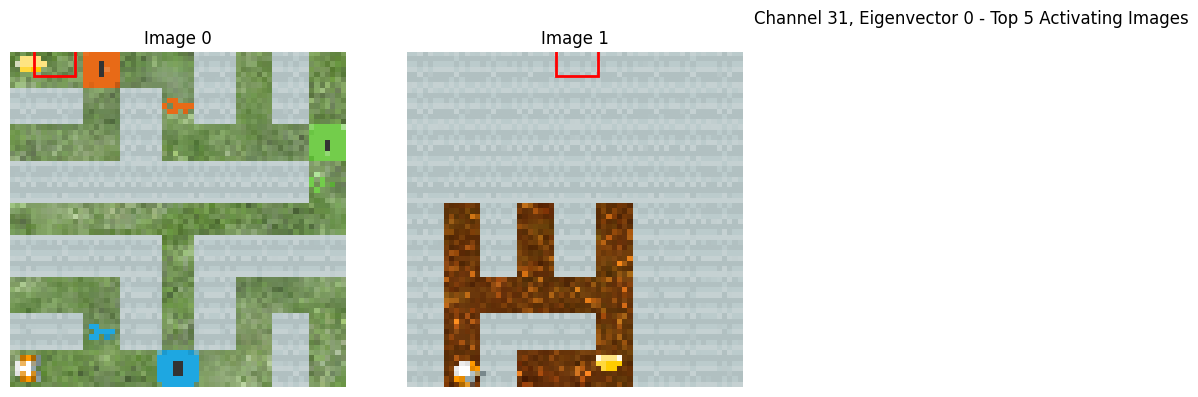

segment size,  8.0 8.0
segment size,  8.0 8.0


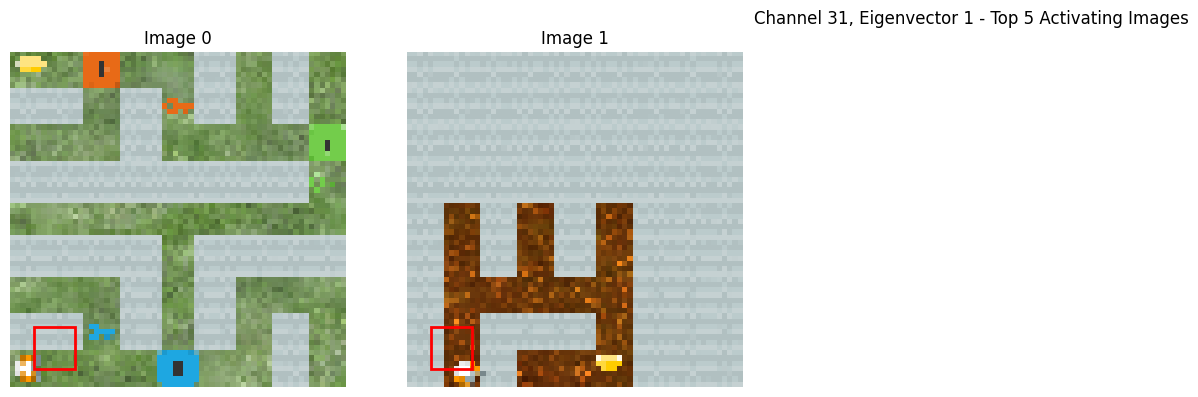

segment size,  8.0 8.0
segment size,  8.0 8.0


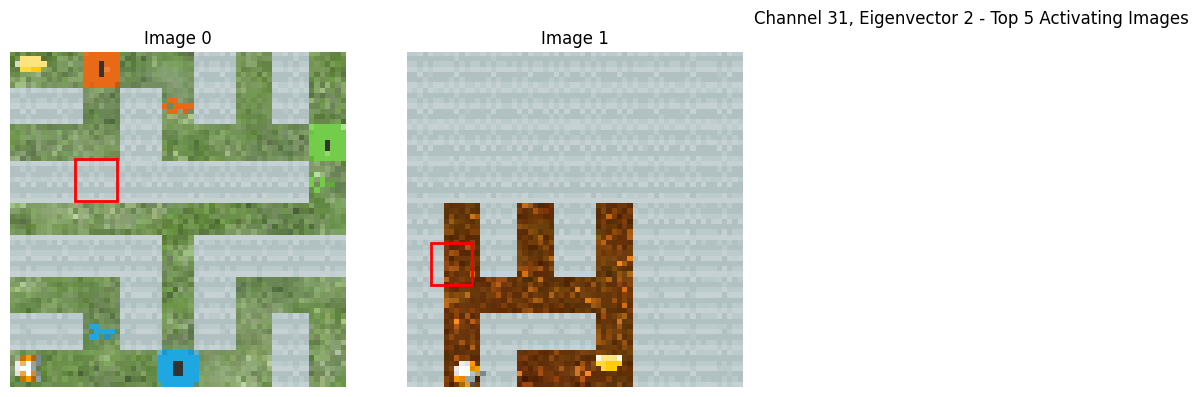

In [22]:
visualizer = EigenvectorVisualizer(model, topk_eigvecs, topk_eigvals,"conv_seqs.2.res_block1" , TensorDataset(dataset[:100]), torch.device("cuda"))
visualizer.process_dataset()
visualizer.display_top_activating_segments()